packageable workflow steps:

pyhull

case foam file -> visualise
case foam file -> resample
case foam file -> conformal map 

hullpredict

load case foam file 

case foam directory -> POD predict


In [ ]:
# =============================================================
#  Conformal‑POD pipeline for Hull + Scalar fields  (with visual grids)
# -------------------------------------------------
#  * Loads multiple .foam hulls, flattens them, resamples pressure onto a
#    template UV mesh.
#  * Builds snapshot matrix, does POD.
#  * Cubic‑IDW interpolates POD coefficients for a new design vector.
#  * Visual grids:
#      1) Original snapshots  → 3‑D hull + UV side‑by‑side grid
#      2) POD modes           → UV grid (first N_modes)
# =============================================================

import os, sys, math
import numpy as np
import pyvista as pv
import igl, vtk
from scipy.linalg import svd
from scipy.spatial import cKDTree
import igl
import numpy as np
import networkx as nx

# -------------------------------------------------------------
# USER SETTINGS
# -------------------------------------------------------------
BASE_DIR   = r"Z:\Zack\Data\Incoming\Cat_parametric_study\Low_Fidelity"
RUN_RANGE  = range(1, 21)             # RUN001 … RUN020
CLIP_TOP   = False                  # open the hull
UV_grid= False                    # use UV mesh for POD (instead of UV mesh of first snapshot as template)
clip_z_off = 1                     # metres to slice off
USE_SQUARE = False                    # circle ➝ False,  square ➝ True
SNAPSHOTS_TO_SHOW = 20                # how many snapshots in the visual grid
MODES_TO_SHOW     = 20                # first POD modes to visualise
predict_xyz = False               # predict x,y,z coordinates of the hull (True) or only the pressure and stress (False)

In [12]:
# def extract_hull_mesh_zxc(foam):
#     # Load the OpenFOAM case file
#     reader = vtk.vtkOpenFOAMReader()
#     # reader.SetFileName("Z:\Zack\Data\Incoming\Cat_parametric_study\High_Fidelity\RUN001\case.foam")
#     # reader.SetFileName('C:/Users/zack/Desktop/RUN001/case.foam')
#     reader.SetFileName(foam)
#     # reader.SetFileName("Z:\Zack\Data\Incoming\Cat_parametric_study\Low_Fidelity\RUN001\case.foam")7
#     reader.DecomposePolyhedraOn()
#     reader.Update()
    
#     print ("Reader output:")

#     # Select only the 'internalMesh' region
#     reader.DisableAllPatchArrays()  # Disable all other patches
#     reader.SetPatchArrayStatus("internalMesh",1)  # Enable internalMesh
#     reader.SetPatchArrayStatus("patch/hull", 1)  # Enable hull mesh (low curvature elements)
#     reader.SetPatchArrayStatus("patch/hull_hc",1)  # Enable hull mesh (high curvature elements)
#     reader.Update()
    
#     print ("Reader output:")

#     # Step 2: Get the multi-block dataset
#     output = reader.GetOutput()

#     ############################
#     # OPTIONAL: Clip the top
#     ############################
#     clip_z_offset = 0.95  # how much to lower the clipping plane

#     # Load hull surface mesh
#     hull_blocks = output.GetBlock(1)
#     hull_meshes = []

#     for i in range(hull_blocks.GetNumberOfBlocks()):
#         sub_block = hull_blocks.GetBlock(i)
#         if isinstance(sub_block, vtk.vtkUnstructuredGrid):
#             poly = pv.wrap(sub_block).extract_surface().triangulate()
#             hull_meshes.append(poly)
#         elif isinstance(sub_block, vtk.vtkPolyData):
#             poly = pv.wrap(sub_block).triangulate()
#             # Convert cell-based pressure to point-based if needed
#             if "p" in poly.cell_data:
#                 poly = poly.cell_data_to_point_data()
#             hull_meshes.append(poly)
            

#     # Combine & surface
#     hull_mesh = pv.MultiBlock(hull_meshes).combine().extract_surface().triangulate()
    
#     print ("Combined hull mesh:")

#     # Optionally clip the top
#     if CLIP_TOP:
#         z_max = hull_mesh.points[:, 2].max()
#         clip_z_max = z_max - clip_z_offset  # user offset
#         clip_plane = vtk.vtkPlane()
#         clip_plane.SetOrigin(0, 0, clip_z_max)
#         clip_plane.SetNormal(0, 0, -1)
#         clipper = vtk.vtkClipPolyData()
#         clipper.SetInputData(hull_mesh)
#         clipper.SetClipFunction(clip_plane)
#         clipper.Update()
#         hull_mesh = pv.wrap(clipper.GetOutput())

#     # Compute cell areas & threshold small triangles
#     hull_mesh["Area"] = hull_mesh.compute_cell_sizes()["Area"]
#     hull_mesh = hull_mesh.threshold(value=1e-7, scalars="Area")
#     hull_mesh = hull_mesh.clean()
    
#     print ("Cleaned hull mesh:")

#     # Check for non-manifold edges
#     feature_edges = vtk.vtkFeatureEdges()
#     feature_edges.SetInputData(hull_mesh)
#     feature_edges.BoundaryEdgesOn()
#     feature_edges.NonManifoldEdgesOn()
#     feature_edges.ManifoldEdgesOff()
#     feature_edges.FeatureEdgesOff()
#     feature_edges.Update()
#     nonmanifold_edges = feature_edges.GetOutput()
#     print("Non-manifold edge count:", nonmanifold_edges.GetNumberOfCells())
    
#     return hull_mesh

In [29]:
import trimesh

# -------------------------------------------------------------
# Helper functions
# -------------------------------------------------------------


# def remove_hull_deck(hull_surface):
#     """
#     Cleans the hull by removing deck faces based on their orientation.

#     Parameters:
#     hull_surface (pyvista.PolyData): The input hull surface mesh.

#     Returns:
#     pyvista.PolyData: The cleaned hull with deck faces removed.
#     """
#     # Extract surface
#     hull_surface = hull_surface.extract_surface()

#     # Compute per-face normals
#     hull_surface = hull_surface.compute_normals(cell_normals=True, point_normals=False, auto_orient_normals=True, consistent_normals=True)

#     # Access the computed cell normals
#     cell_normals = hull_surface.cell_data["Normals"]  # shape: (N_faces, 3)
    
#     normals = hull_surface.cell_data["Normals"]
#     cell_centers = hull_surface.cell_centers().points
#     signs = np.einsum("ij,ij->i", normals, cell_centers - hull_surface.center)

#     if np.any(signs < 0):
#         print("⚠️ Some normals point inward!")
#     else:
#         print("✅ All normals point outward.")


#     # Dot product with upward vector
#     up_vector = np.array([0, 0, 1])
#     dot_products = np.dot(cell_normals, up_vector)

#     # Set threshold (e.g., dot product > 0.95 means almost perfectly upwards)
#     threshold = 0.55
#     is_deck_face = dot_products > threshold

#     # Mask out (remove) deck faces
#     faces_to_keep = ~is_deck_face

#     # Extract faces to keep
#     ids = np.nonzero(faces_to_keep)[0]
#     cleaned_hull = hull_surface.extract_cells(ids).clean().extract_surface()
    
#     faces = cleaned_hull.faces.reshape(-1, 4)[:, 1:]
#     vertices = cleaned_hull.points
#     original_point_scalars = dict(cleaned_hull.point_data)
#     original_cell_scalars = dict(cleaned_hull.cell_data)

#     # Step 4: Convert to trimesh
#     trimesh_hull = trimesh.Trimesh(vertices=vertices, faces=faces, process=False)

#     # Step 5: Count boundary edges per face
#     edge_face_map = {}
#     for face_idx, face in enumerate(trimesh_hull.faces):
#         edges = [tuple(sorted((face[i], face[(i+1)%3]))) for i in range(3)]
#         for edge in edges:
#             edge_face_map.setdefault(edge, []).append(face_idx)

#     face_boundary_count = np.zeros(len(trimesh_hull.faces), dtype=int)
#     for face_list in edge_face_map.values():
#         if len(face_list) == 1:
#             face_boundary_count[face_list[0]] += 1

#     # Step 6: Identify and remove weakly connected faces
#     bad_faces = np.where(face_boundary_count >= 2)[0]
#     face_mask = np.ones(len(trimesh_hull.faces), dtype=bool)
#     face_mask[bad_faces] = False
#     filtered_faces = trimesh_hull.faces[face_mask]

#     # Step 7: Track vertex usage and remap indices
#     used_vertices_idx = np.unique(filtered_faces)
#     new_vertex_map = {old: new for new, old in enumerate(used_vertices_idx)}
#     remapped_faces = np.vectorize(new_vertex_map.get)(filtered_faces)
#     new_vertices = vertices[used_vertices_idx]

#     # Step 8: Rebuild mesh with preserved scalars
#     face_cells = np.hstack([np.full((remapped_faces.shape[0], 1), 3), remapped_faces])
#     final_mesh = pv.PolyData(new_vertices, face_cells)

#     # Map point scalars
#     for name, array in original_point_scalars.items():
#         if len(array) == len(vertices):
#             final_mesh.point_data[name] = array[used_vertices_idx]

#     # Map cell scalars
#     for name, array in original_cell_scalars.items():
#         if len(array) == len(face_mask):
#             final_mesh.cell_data[name] = array[face_mask]

#     return final_mesh

import numpy as np
import pyvista as pv
import trimesh

def remove_hull_deck(hull_surface):
    """
    Cleans the hull by removing deck faces based on their orientation.

    Parameters:
    hull_surface (pyvista.PolyData): The input hull surface mesh (tri or quad).

    Returns:
    pyvista.PolyData: The cleaned hull with deck faces removed.
    """
    import numpy as np
    import pyvista as pv

    # Extract surface
    hull_surface = hull_surface.extract_surface()

    # Compute per-face normals
    hull_surface = hull_surface.compute_normals(cell_normals=True, point_normals=False,
                                                auto_orient_normals=True, consistent_normals=True)

    # Check for inward normals
    normals = hull_surface.cell_data["Normals"]
    cell_centers = hull_surface.cell_centers().points
    signs = np.einsum("ij,ij->i", normals, cell_centers - hull_surface.center)
    if np.any(signs < 0):
        print("⚠️ Some normals point inward!")
    else:
        print("✅ All normals point outward.")

    # Identify top-facing faces based on upward normal
    up_vector = np.array([0, 0, 1])
    dot_products = np.dot(normals, up_vector)
    threshold = 0.75
    is_deck_face = dot_products > threshold

    # Mask out (remove) deck faces
    faces_to_keep = ~is_deck_face
    ids = np.nonzero(faces_to_keep)[0]

    # Extract faces to keep
    cleaned_hull = hull_surface.extract_cells(ids).clean().extract_surface()
    print ("Cleaned hull mesh:")
    return cleaned_hull


# import numpy as np
# import pyvista as pv
# import trimesh

# def remove_hull_deck(hull_surface, tri_only=True):
#     """
#     Removes upward-facing deck faces and weakly connected boundary faces.
#     Optionally restricts to triangle-only processing.

#     Parameters:
#     - hull_surface (pyvista.PolyData): The input surface mesh.
#     - tri_only (bool): If True, convert to triangle-only mesh. If False, preserve quads.

#     Returns:
#     - pv.PolyData: Cleaned mesh.
#     """
#     # Step 1: Clean and extract surface
#     hull_surface = hull_surface.extract_surface()
#     if tri_only:
#         hull_surface = hull_surface.triangulate()

#     hull_surface = hull_surface.compute_normals(
#         cell_normals=True, point_normals=False,
#         auto_orient_normals=True, consistent_normals=True
#     )

#     # Step 2: Inward normals check
#     normals = hull_surface.cell_data["Normals"]
#     cell_centers = hull_surface.cell_centers().points
#     signs = np.einsum("ij,ij->i", normals, cell_centers - hull_surface.center)

#     if np.any(signs < 0):
#         print("⚠️ Some normals point inward!")
#     else:
#         print("✅ All normals point outward.")

#     # Step 3: Remove deck faces based on upward normal
#     up_vector = np.array([0, 0, 1])
#     dot_products = np.dot(normals, up_vector)
#     is_deck_face = dot_products > 0.55
#     faces_to_keep = ~is_deck_face
#     ids = np.nonzero(faces_to_keep)[0]

#     cleaned_hull = hull_surface.extract_cells(ids).clean().extract_surface()

#     # Step 4: Extract face connectivity and scalars
#     face_arr = cleaned_hull.faces
#     n_faces = cleaned_hull.n_faces
#     n_points = cleaned_hull.n_points
#     vertices = cleaned_hull.points
#     face_sizes = face_arr[::face_arr[0] + 1]  # size = 3 or 4, etc.

#     if tri_only:
#         faces = face_arr.reshape(-1, 4)[:, 1:]
#     else:
#         # General polygon support — extract all triangle faces only for edge filtering
#         faces = []
#         offset = 0
#         while offset < len(face_arr):
#             n = face_arr[offset]
#             face = face_arr[offset + 1: offset + 1 + n]
#             if n == 3:
#                 faces.append(face)
#             offset += 1 + n
#         faces = np.array(faces)

#     original_point_scalars = dict(cleaned_hull.point_data)
#     original_cell_scalars = dict(cleaned_hull.cell_data)

#     # Step 5: Trimesh to detect weakly connected faces
#     trimesh_hull = trimesh.Trimesh(vertices=vertices, faces=faces, process=False)
#     edge_face_map = {}
#     for face_idx, face in enumerate(trimesh_hull.faces):
#         edges = [tuple(sorted((face[i], face[(i+1)%3]))) for i in range(3)]
#         for edge in edges:
#             edge_face_map.setdefault(edge, []).append(face_idx)

#     face_boundary_count = np.zeros(len(trimesh_hull.faces), dtype=int)
#     for face_list in edge_face_map.values():
#         if len(face_list) == 1:
#             face_boundary_count[face_list[0]] += 1

#     bad_faces = np.where(face_boundary_count >= 2)[0]
#     face_mask = np.ones(len(trimesh_hull.faces), dtype=bool)
#     face_mask[bad_faces] = False
#     filtered_faces = trimesh_hull.faces[face_mask]

#     # Step 6: Remap indices and reconstruct mesh
#     if filtered_faces.size == 0:
#         print("⚠️ No faces left after boundary filtering — returning empty mesh.")
#         return pv.PolyData()

#     used_vertices_idx = np.unique(filtered_faces)
#     new_vertex_map = {old: new for new, old in enumerate(used_vertices_idx)}
#     remapped_faces = np.vectorize(new_vertex_map.get, otypes=[int])(filtered_faces)

#     new_vertices = vertices[used_vertices_idx]

#     # Convert back to PolyData
#     face_cells = np.hstack([np.full((remapped_faces.shape[0], 1), 3), remapped_faces])
#     final_mesh = pv.PolyData(new_vertices, face_cells)

#     # Step 7: Restore point scalars
#     for name, array in original_point_scalars.items():
#         if len(array) == len(vertices):
#             final_mesh.point_data[name] = array[used_vertices_idx]

#     # Step 8: Restore cell scalars (only valid if tri_only)
#     if tri_only:
#         for name, array in original_cell_scalars.items():
#             if len(array) == len(face_mask):
#                 final_mesh.cell_data[name] = array[face_mask]

#     return final_mesh


def extract_hull_mesh(foam_path: str) -> pv.PolyData:
    rdr = vtk.vtkOpenFOAMReader()
    rdr.SetFileName(foam_path)
    rdr.DecomposePolyhedraOn()

    rdr.DisableAllPatchArrays()
    rdr.SetPatchArrayStatus("internalMesh", 1)
    rdr.SetPatchArrayStatus("patch/hull", 1)
    rdr.SetPatchArrayStatus("patch/hull_hc", 1)
    rdr.Update()

    mblock = rdr.GetOutput()
    hull_blocks = mblock.GetBlock(1)
    pieces = []
    for i in range(hull_blocks.GetNumberOfBlocks()):
        sub = hull_blocks.GetBlock(i)
        # poly = pv.wrap(sub).extract_surface().triangulate()
        poly = pv.wrap(sub).extract_surface()
        if "p" in poly.cell_data:
            poly = poly.cell_data_to_point_data()
        pieces.append(poly)

    hull = pv.MultiBlock(pieces).combine().extract_surface().clean()
    # hull = hull.triangulate().decimate_boundary(0.01)
    # hull_cleaned = remove_hull_deck(pv.MultiBlock(pieces).combine().extract_surface()).triangulate() # attempt at triangulating after deck is removed
    # hull = hull_cleaned.copy()
    
    # Optionally clip the top
    if CLIP_TOP:
        z_max = hull.points[:, 2].max()
        clip_z_max = z_max - clip_z_off  # user offset
        clip_plane = vtk.vtkPlane()
        clip_plane.SetOrigin(0, 0, clip_z_max)
        clip_plane.SetNormal(0, 0, -1)
        clipper = vtk.vtkClipPolyData()
        clipper.SetInputData(hull)
        clipper.SetClipFunction(clip_plane)
        clipper.Update()
        hull = pv.wrap(clipper.GetOutput())

    hull["Area"] = hull.compute_cell_sizes()["Area"]
    # hull = hull.threshold(value=1e-8, scalars="Area").clean()
    hull = hull.threshold(value=1e-7, scalars="Area").clean()
    
    # Check for non-manifold edges
    feature_edges = vtk.vtkFeatureEdges()
    feature_edges.SetInputData(hull)
    feature_edges.BoundaryEdgesOn()
    feature_edges.NonManifoldEdgesOn()
    feature_edges.ManifoldEdgesOff()
    feature_edges.FeatureEdgesOff()
    feature_edges.Update()
    nonmanifold_edges = feature_edges.GetOutput()
    print("Non-manifold edge count:", nonmanifold_edges.GetNumberOfCells())

    return hull

def map_vertices_to_square(V, b):
    B = V[b]
    seg = np.linalg.norm(B - np.roll(B, -1, axis=0), axis=1)
    cum = np.insert(np.cumsum(seg), 0, 0.0)[:-1]
    cum /= cum[-1] + seg[-1]
    t = 4*cum
    uv = np.zeros((len(b),2))
    for i,s in enumerate(t):
        if s<1: uv[i]=[s,0]
        elif s<2: uv[i]=[1,s-1]
        elif s<3: uv[i]=[3-s,1]
        else: uv[i]=[0,4-s]
    return uv


# def harmonic_uv(V,F,to_square=False):
    
#     b = igl.boundary_loop(F)
#     if to_square:
#         bnd_uv = map_vertices_to_square(V,b)
#     else:
#         bnd_uv = igl.map_vertices_to_circle(V,b)
#     return igl.harmonic(V,F,b,bnd_uv.astype(V.dtype),1)


def harmonic_uv(V, F, boundary_indices=None, to_square=False):
    """
    Computes a harmonic UV map using a consistent boundary loop.

    Parameters:
    - V: (n_pts, 3) vertex coordinates
    - F: (n_faces, 3) triangle indices
    - to_square: whether to map the boundary to a square (default False → circle)
    - boundary_indices: optional (n_bnd,) array of boundary vertex indices (default uses igl.boundary_loop)

    Returns:
    - UV: (n_pts, 2) array of UV coordinates
    """
    if boundary_indices is None:
        boundary_indices = igl.boundary_loop(F)

    if to_square:
        bnd_uv = map_vertices_to_square(V, boundary_indices)
    else:
        bnd_uv = igl.map_vertices_to_circle(V, boundary_indices)

    UV = igl.harmonic(V, F, boundary_indices, bnd_uv.astype(V.dtype), 1)
    return UV



def get_consistent_boundary_loop(V: np.ndarray, F: np.ndarray):
    """
    Extract a consistently ordered boundary loop from a surface mesh.
    
    Parameters
    ----------
    V : (n_vertices, 3) float array
        Vertex coordinates.
    F : (n_faces, 3) int array
        Triangle face indices.

    Returns
    -------
    loop_indices : List[int]
        Ordered indices of the boundary loop.
    """
    # Extract boundary edges
    boundary_edges = igl.boundary_facets(F)

    # Build connectivity graph
    G = nx.Graph()
    G.add_edges_from(map(tuple, boundary_edges))

    # Find all connected boundary loops
    loops = list(nx.connected_components(G))
    loops_sorted = sorted(loops, key=len, reverse=True)

    # Take the largest loop
    if not loops_sorted:
        raise RuntimeError("No boundary loop found.")
    
    largest_loop = loops_sorted[0]
    subgraph = G.subgraph(largest_loop)

    # Traverse in order using depth-first search
    path = list(nx.dfs_edges(subgraph))
    if not path:
        raise RuntimeError("Could not order boundary loop.")

    ordered_loop = [path[0][0]] + [v for _, v in path]
    return np.array(ordered_loop)

def reorder_loop_start(V, loop_indices):
    """
    Reorder a loop so it starts at the vertex with the smallest x-coordinate.

    Parameters
    ----------
    V : (n_vertices, 3) ndarray
        Vertex coordinates.
    loop_indices : list or array
        Ordered boundary loop indices.

    Returns
    -------
    reordered_loop : list of int
        Loop starting from the leftmost point.
    """
    loop_pts = V[loop_indices]
    start_idx = np.argmin(loop_pts[:, 0])  # Smallest x-coordinate
    return np.roll(loop_indices, -start_idx)


In [14]:
# # -------------------------------------------------------------
# # 5)  VISUALISE FIRST POD MODES IN UV SPACE (per scalar field)
# # -------------------------------------------------------------
# MODES_TO_SHOW = 20  # Number of POD modes to visualize
# npts = len(UV_query) if UV_grid else len(UV0)

# if predict_xyz:
#     scalar_names = ['Cp', 'tauw_0', 'tauw_1', 'tauw_2', 'X', 'Y', 'Z']
# else: 
#     scalar_names = ['Cp', 'tauw_0', 'tauw_1', 'tauw_2']
    
# num_scalars = len(scalar_names)

# assert U.shape[0] == npts * num_scalars, "POD modes size mismatch with fields!"

# # Plot
# mode_plot = pv.Plotter(shape=(MODES_TO_SHOW, num_scalars), window_size=(350*num_scalars, 250*MODES_TO_SHOW))

# for mode_idx in range(MODES_TO_SHOW):
#     full_mode_vec = U[:, mode_idx]  # Full flattened mode vector
#     mode_fields = np.split(full_mode_vec, num_scalars)  # One array per scalar

#     for field_idx, field_vals in enumerate(mode_fields):
#         if UV_grid:
#             mesh_uv = pv.StructuredGrid(UU, VV, np.zeros_like(UU))
#         else:
#             uv_pts = np.column_stack((UV0, np.zeros(len(UV0))))
#             mesh_uv = pv.PolyData(uv_pts, faces_pv.copy())

#         mesh_uv.point_data["mode_field"] = field_vals

#         # Setup subplot
#         mode_plot.subplot(mode_idx, field_idx)
#         mode_plot.add_mesh(mesh_uv, scalars="mode_field", cmap="coolwarm", show_edges=False)

#         # Text and camera
#         mode_plot.add_text(f"Mode {mode_idx+1} - {scalar_names[field_idx]}", font_size=8)
#         mode_plot.view_xy()

# mode_plot.show()



In [23]:
import pyvista as pv
import numpy as np

def plot_ordered_boundary(V, loop_indices):
    """
    Visualize an ordered boundary loop on a 3D mesh.

    Parameters
    ----------
    V : (n_vertices, 3) ndarray
        Vertex coordinates.
    loop_indices : list or ndarray of int
        Ordered boundary vertex indices.
    """
    loop_pts = V[loop_indices]

    # Create PolyData for boundary points
    point_cloud = pv.PolyData(loop_pts)
    point_cloud['index'] = np.arange(len(loop_pts))  # Scalar for coloring

    # Create lines connecting the loop points
    lines = []
    for i in range(len(loop_pts) - 1):
        lines.append([2, i, i+1])
    lines.append([2, len(loop_pts)-1, 0])  # Close the loop

    loop_lines = pv.PolyData()
    loop_lines.points = loop_pts
    loop_lines.lines = np.hstack(lines)

    # Plot
    p = pv.Plotter()
    p.add_mesh(point_cloud, scalars='index', cmap='plasma', point_size=8, render_points_as_spheres=True)
    p.add_mesh(loop_lines, color='black', line_width=2)
    p.add_text("Ordered Boundary Loop", font_size=12)
    p.show()


In [31]:
# -------------------------------------------------------------
# 1) LOAD CASES
# -------------------------------------------------------------
print("Loading cases …")
case_paths = [(f"RUN{i:03d}", os.path.join(BASE_DIR, f"RUN{i:03d}", "case.foam"))
              for i in RUN_RANGE if os.path.exists(os.path.join(BASE_DIR, f"RUN{i:03d}", "case.foam"))]
if not case_paths:
    sys.exit("No .foam files found – check BASE_DIR.")

# template build
run0, foam0 = case_paths[0]
hull0 = extract_hull_mesh(foam0)
hull0 = remove_hull_deck(hull0).clean()
print ('triangulating hull0')
hull0 = hull0.triangulate()
print ("hull0 triangulated")
V0 = hull0.points.astype(float)
F0 = hull0.faces.reshape(-1,4)[:,1:].astype(np.int32)
if UV_grid:
    # Instead of UV0 = harmonic_uv(V0, F0)
    
    # Prepare UV sampling grid
    nu = nv = 100
    u_lin = np.linspace(0,1,nu)
    v_lin = np.linspace(0,1,nv)
    UU, VV = np.meshgrid(u_lin, v_lin)
    UV_query = np.column_stack((UU.ravel(), VV.ravel()))
    M = UV_query.shape[0]

    print("UV sampling grid:")
    print(f"  {nu} x {nv} = {M} points")

    # u_lin = np.linspace(0, 1, nu)
    # v_lin = np.linspace(0, 1, nv)
    # UU, VV = np.meshgrid(u_lin, v_lin)
    UV0 = np.column_stack((UU.ravel(), VV.ravel()))
else:
    print ("UV grid not used, using original hull mesh")
    # reorder boundary loop indices
    loop_indices0 = get_consistent_boundary_loop(V0, F0)
    loop_fixed_start = reorder_loop_start(V0, loop_indices0)
    plot_ordered_boundary(V0, loop_fixed_start)
    UV0 = harmonic_uv(V0, F0, boundary_indices=loop_fixed_start, to_square=USE_SQUARE) # this version takes in ordered boundary indices
    # UV0 = harmonic_uv(V0,F0,USE_SQUARE)
    
faces_pv = np.hstack((np.full((F0.shape[0],1),3),F0)).astype(int)

Loading cases …


ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (00000280DC3CC6E0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0
⚠️ Some normals point inward!
Cleaned hull mesh:
triangulating hull0
hull0 triangulated
UV grid not used, using original hull mesh


Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x280500f52b0_25&reconnect=auto" class="pyvi…

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-7998' coro=<WebSocketWriter.ping() done, defined at c:\Users\zack\AppData\Local\anaconda3\Lib\site-packages\aiohttp\http_websocket.py:711> exception=ConnectionResetError('Cannot write to closing transport')>
Traceback (most recent call last):
  File "c:\Users\zack\AppData\Local\anaconda3\Lib\asyncio\tasks.py", line 314, in __step_run_and_handle_result
    result = coro.send(None)
             ^^^^^^^^^^^^^^^
  File "c:\Users\zack\AppData\Local\anaconda3\Lib\site-packages\aiohttp\http_websocket.py", line 715, in ping
    await self._send_frame(message, WSMsgType.PING)
  File "c:\Users\zack\AppData\Local\anaconda3\Lib\site-packages\aiohttp\http_websocket.py", line 682, in _send_frame
    self._write(header + message)
  File "c:\Users\zack\AppData\Local\anaconda3\Lib\site-packages\aiohttp\http_websocket.py", line 702, in _write
    raise ConnectionResetError("Cannot write to closing transport")
ConnectionRe

# TODO list

- Re run hulls with open surfaces (additional patch)
- Modularize for multiple scalars: surface pressure 'p', surface shear stress 'tau'
- Predict free surface
- Adapt Gappy POD
- package workflow

In [16]:
# # Visualize the harmonic UV map
# uv_pts_cleaned = np.column_stack((UV_cleaned, np.zeros(len(UV_cleaned))))
# faces_cleaned = np.hstack((np.full((F_cleaned.shape[0], 1), 3), F_cleaned)).astype(int)
# mesh_uv_cleaned = pv.PolyData(uv_pts_cleaned, faces_cleaned)

# plotter = pv.Plotter()
# plotter.add_mesh(mesh_uv_cleaned, scalars=p_scalar, cmap="coolwarm", show_edges=True)
# plotter.add_text("Harmonic UV Map of Cleaned Hull", font_size=12)
# plotter.show()

# # # Visualize the harmonic UV map for the template
# # uv_pts_template = np.column_stack((UV0, np.zeros(len(UV0))))
# # faces_template = np.hstack((np.full((F0.shape[0], 1), 3), F0)).astype(int)
# # mesh_uv_template = pv.PolyData(uv_pts_template, faces_template)

# # plotter = pv.Plotter()
# # plotter.add_mesh(mesh_uv_template, scalars='None', cmap="coolwarm", show_edges=True)
# # plotter.add_text("Harmonic UV Map for Template", font_size=12)
# # plotter.show()

In [17]:
# from scipy.interpolate import LinearNDInterpolator

# #-------------------------------------------------------------
# # 2) Prepare UV sampling grid
# #-------------------------------------------------------------

# nu = nv = 100
# u_lin = np.linspace(0,1,nu)
# v_lin = np.linspace(0,1,nv)
# UU, VV = np.meshgrid(u_lin, v_lin)
# UV_query = np.column_stack((UU.ravel(), VV.ravel()))
# M = UV_query.shape[0]

# print("UV sampling grid:")
# print(f"  {nu} x {nv} = {M} points")

# #-------------------------------------------------------------
# # 3) Process snapshots: fast linear interpolation
# #-------------------------------------------------------------
# # containers
# uv_widgets = []
# pressure_snap, geomX, geomY, geomZ = [], [], [], []
# all_hull_meshes, all_uv_meshes = [], []

# for idx, case in enumerate(case_paths):
#     rid, fp = case
#     print(f"Snapshot {rid}")
#     hull = extract_hull_mesh_zxc(fp)
#     print ("Hull mesh extracted")
#     V = hull.points
#     F = hull.cells.reshape(-1, 4)[:, 1:]
#     UV_src = harmonic_uv(V, F)
#     print ("Harmonic UV mesh extracted")
#     P_src = hull['p'].astype(float)
#     print ("Pressure data extracted")
#     # Setup linear interpolator in UV space
#     interp = LinearNDInterpolator(UV_src, P_src, fill_value=np.nan)
#     print ("Linear interpolator set up")
#     # Sample over uniform UV grid
#     P_grid = interp(UV_query)
    
#     # handle any nans (outside convex hull, rare)
#     nan_mask = np.isnan(P_grid)
#     if nan_mask.any():
#         # fallback: nearest neighbor
#         from scipy.spatial import cKDTree
#         tree = cKDTree(UV_src)
#         _, idx_nn = tree.query(UV_query[nan_mask])
#         P_grid[nan_mask] = P_src[idx_nn]

#     pressure_snap.append(P_grid)

#     if idx < SNAPSHOTS_TO_SHOW:
#         grid = pv.StructuredGrid(UU, VV, np.zeros_like(UU))
#         grid.point_data['p'] = P_grid
#         uv_widgets.append(grid)

# # visualize snapshots in UV
# plt = pv.Plotter(shape=(SNAPSHOTS_TO_SHOW,1), window_size=(400,200*SNAPSHOTS_TO_SHOW))
# for k, grid in enumerate(uv_widgets):
#     plt.subplot(k,0)
#     plt.add_mesh(grid, scalars='p', cmap='coolwarm', show_edges=False)
#     plt.add_text(case_paths[k][0], font_size=8)
# plt.show()


In [18]:
# #-------------------------------------------------------------
# # 2) SNAPSHOT PROCESSING & RESAMPLING (with uniform UV grid)
# #-------------------------------------------------------------
# from scipy.interpolate import griddata


# pressure_snap, geomX, geomY, geomZ = [], [], [], []
# all_hull_meshes, all_uv_meshes = [], []

# for idx, (rid, fp) in enumerate(case_paths):
#     hull = extract_hull_mesh(fp)
#     V = hull.points.astype(np.float64)
#     F = hull.cells.reshape(-1, 4)[:, 1:].astype(np.int32)
#     if "p" not in hull.point_data:
#         raise RuntimeError(f"pressure missing in {rid}")

#     UV_src = harmonic_uv(V, F, USE_SQUARE)
#     P_src = hull.point_data["p"].astype(float)

#     # Interpolate pressure onto uniform UV grid
#     P_grid = griddata(UV_src, P_src, UV_query, method='linear', fill_value=np.nan)

#     # Handle NaNs by nearest-neighbor interpolation
#     nan_mask = np.isnan(P_grid)
#     if np.any(nan_mask):
#         P_grid[nan_mask] = griddata(UV_src, P_src, UV_query[nan_mask], method='nearest')

#     pressure_snap.append(P_grid)
#     geomX.append(V[:, 0])
#     geomY.append(V[:, 1])
#     geomZ.append(V[:, 2])

#     # store for visual grid (first SNAPSHOTS_TO_SHOW)
#     if len(all_hull_meshes) <= SNAPSHOTS_TO_SHOW:
#         m3d = hull.copy()
#         m3d.point_data["p"] = hull.point_data["p"]
#         all_hull_meshes.append(m3d)

#         uv_pts = np.column_stack((UV_query, np.zeros(len(UV_query))))
#         faces_pv = []  # Using structured grid, no need for faces explicitly
#         m2d = pv.StructuredGrid(UU, VV, np.zeros_like(UU))
#         m2d.point_data["p"] = P_grid
#         all_uv_meshes.append(m2d)



In [ ]:
from scipy.interpolate import griddata

#-------------------------------------------------------------
# 2) SNAPSHOT PROCESSING & RESAMPLING (with template)
#-------------------------------------------------------------

response_snap, geomX, geomY, geomZ=[],[],[],[]
all_hull_meshes, all_uv_meshes=[],[]
# --- Normalization containers ---
Cp_all = []
tau_all = [[] for _ in range(3)]  # One for each component

for idx,(rid,fp) in enumerate(case_paths):
    hull = extract_hull_mesh(fp)
    hull = remove_hull_deck(hull)
    hull = hull.triangulate()
    V    = hull.points.astype(np.float64)
    F    = hull.faces.reshape(-1,4)[:,1:].astype(np.int32)
    
    if "p" not in hull.point_data or "tauw" not in hull.point_data:
        raise RuntimeError(f"Required scalars missing in {rid}")
    
    # Original scalar pressure
    p_scalar = hull.point_data["p"].astype(float)
    tau_wall = hull.point_data["tauw"].astype(float)  # shape (N, 3)
    
    # print ('p_scalar ', p_scalar[:100] )
    # print ('tau_wall_0', tau_wall[0][:100])

    # ---- Step to non-dimensionalize pressure ---- #
    p_inf = 0           # freestream (or gauge) pressure
    rho = 1025          # fluid density (e.g., seawater)
    U = 6.1728          # reference velocity

    # trying without *0.5 (for marine)
    Cp_scalar = (p_scalar - p_inf) / (rho * U**2) # non-dimensionalized pressure
    tau_wall_nd = tau_wall / (rho * U**2) # non-dimensionalized wall shear stress  
    # ------------------------------------------------------ #

    hull.point_data["Cp"] = Cp_scalar  # store non-dimensionalized pressure
    for i in range(3):
        hull.point_data[f"tau_nd_{i}"] = tau_wall[:, i] / (0.5 * rho * U**2) # store non-dimensionalized wall shear stress components


    # hull.point_data["tauw"] = tau_wall # store wall shear stress
    # ------------------------------------------------------ #

    if UV_grid:
        
        # re-order boundary loop for UV mapping
        loop_indices = get_consistent_boundary_loop(V, F)
        loop_fixed_start = reorder_loop_start(V, loop_indices)
        plot_ordered_boundary(V, loop_fixed_start)
        # Use a resmpled structured UV grid for POD ()
        UV_src = harmonic_uv(V, F, boundary_indices=loop_fixed_start, to_square=USE_SQUARE) # this version uses ordered boundary loop
        # UV_src = harmonic_uv(V, F, USE_SQUARE)
        # P_src = hull.point_data["p"].astype(float)
        # P_src = Cp_scalar  # Use the non-dimensionalized pressure for POD

        # Interpolate pressure onto uniform UV grid
        Cp_template = griddata(UV_src, Cp_scalar, UV_query, method='linear', fill_value=np.nan)
        tau_templates = [
            griddata(UV_src, tau_wall_nd[:,i], UV_query, method='linear', fill_value=np.nan)
            for i in range(3)
        ]
        if predict_xyz:
            # Interpolate also coordinates onto UV grid
            X_template = griddata(UV_src, V[:,0], UV_query, method='linear', fill_value=np.nan)
            Y_template = griddata(UV_src, V[:,1], UV_query, method='linear', fill_value=np.nan)
            Z_template = griddata(UV_src, V[:,2], UV_query, method='linear', fill_value=np.nan)


        # Handle NaNs
        nan_mask_cp = np.isnan(Cp_template)
        if np.any(nan_mask_cp):
            Cp_template[nan_mask_cp] = griddata(UV_src, Cp_scalar, UV_query[nan_mask_cp], method='nearest')
        for i in range(3):
            nan_mask_tau = np.isnan(tau_templates[i])
            if np.any(nan_mask_tau):
                tau_templates[i][nan_mask_tau] = griddata(UV_src, tau_wall_nd[:, i], UV_query[nan_mask_tau], method='nearest')
        if predict_xyz:
            for template, coord in zip([X_template, Y_template, Z_template], [0, 1, 2]):
                nan_mask = np.isnan(template)
                if np.any(nan_mask):
                    template[nan_mask] = griddata(UV_src, V[:, coord], UV_query[nan_mask], method='nearest')
    
        
    else: 
        # Resample scala fields onto template UV
        if np.array_equal(F, F0):
            # P_template = hull.point_data["p"]
            Cp_template = Cp_scalar
            tau_templates = [tau_wall_nd[:,i] for i in range(3)]
            
            if predict_xyz:
                # Interpolate also coordinates onto UV grid
                X_template = V[:,0]
                Y_template = V[:,1]
                Z_template = V[:,2]
            print ("here")
        else:
            # re-order boundary loop for UV mapping
            loop_indices = get_consistent_boundary_loop(V, F)
            loop_fixed_start = reorder_loop_start(V, loop_indices)
            plot_ordered_boundary(V, loop_fixed_start)
            # Use the original UV mesh (first snapshot) for POD 
            UV_src = harmonic_uv(V, F, boundary_indices=loop_fixed_start, to_square=USE_SQUARE) # this version uses ordered boundary loop
            # UV_src = harmonic_uv(V, F, USE_SQUARE)
            tris_uv = UV_src[F]
            cent    = tris_uv.mean(axis=1)
            tree    = cKDTree(cent)
            uv_min  = tris_uv.min(axis=1)
            uv_max  = tris_uv.max(axis=1)
            # P_src   = hull.point_data["p"].astype(float)
            # P_src = Cp_scalar  # Use the non-dimensionalized pressure for POD
            
            Cp_template = np.empty(len(UV0))
            tau_templates = [np.empty(len(UV0)) for _ in range(3)]
            if predict_xyz:
                # Interpolate also coordinates onto UV grid
                X_template = np.empty(len(UV0))
                Y_template = np.empty(len(UV0))
                Z_template = np.empty(len(UV0))
    
            
            def bary(pt, a, b, c):
                v0 = c - a; v1 = b - a; v2 = pt - a
                d00, d01, d11 = v0 @ v0, v0 @ v1, v1 @ v1
                d02, d12      = v0 @ v2, v1 @ v2
                inv = 1.0/(d00*d11 - d01*d01 + 1e-15)
                u = (d11*d02 - d01*d12)*inv
                v = (d00*d12 - d01*d02)*inv
                return (u >= 0 and v >= 0 and u + v <= 1), np.array([1-u-v, v, u])
            
            for j, pt in enumerate(UV0):
                _, candidates = tree.query(pt, k=8, distance_upper_bound=0.2)
                val_cp, val_tau = None, [None]*3
                for t in candidates:
                    if t >= len(F):
                        continue
                    if not ((uv_min[t] <= pt).all() and (pt <= uv_max[t]).all()):
                        continue
                    i0, i1, i2 = F[t]
                    ok, w = bary(pt, UV_src[i0], UV_src[i1], UV_src[i2])
                    if ok:
                        val_cp = w[0]*Cp_scalar[i0] + w[1]*Cp_scalar[i1] + w[2]*Cp_scalar[i2]
                        for i in range(3):
                            val_tau[i] = w[0]*tau_wall_nd[i0,i] + w[1]*tau_wall_nd[i1,i] + w[2]*tau_wall_nd[i2,i]
                        if predict_xyz:
                            val_x = w[0]*V[i0,0] + w[1]*V[i1,0] + w[2]*V[i2,0]
                            val_y = w[0]*V[i0,1] + w[1]*V[i1,1] + w[2]*V[i2,1]
                            val_z = w[0]*V[i0,2] + w[1]*V[i1,2] + w[2]*V[i2,2]
                        break
                if val_cp is None:
                    _, nn = tree.query(pt)
                    val_cp = Cp_scalar[F[nn, 0]]
                    for i in range(3):
                        val_tau[i] = tau_wall_nd[F[nn, 0], i]
                    if predict_xyz:
                        val_x = V[F[nn,0],0]
                        val_y = V[F[nn,0],1]
                        val_z = V[F[nn,0],2]
                        
                Cp_template[j] = val_cp
                for i in range(3):
                    tau_templates[i][j] = val_tau[i]
                if predict_xyz:
                    X_template[j] = val_x
                    Y_template[j] = val_y
                    Z_template[j] = val_z
                

    # --- Assemble snapshot vector ---
    if predict_xyz:
        snapshot_vec = np.hstack((Cp_template, *tau_templates, X_template, Y_template, Z_template))
        
    else:
        snapshot_vec = np.hstack((Cp_template, *tau_templates))
        
    response_snap.append(snapshot_vec)
    
    # Collect unnormalized values for global scaling
    Cp_all.append(Cp_template)
    for i in range(3):
        tau_all[i].append(tau_templates[i])

    if predict_xyz:
        # geomX.append(V[:,0]); geomY.append(V[:,1]); geomZ.append(V[:,2])
        geomX.append(X_template)
        geomY.append(Y_template)
        geomZ.append(Z_template)


    # store for visual grid (first SNAPSHOTS_TO_SHOW)
    if len(all_hull_meshes) <= SNAPSHOTS_TO_SHOW:
        m3d = hull.copy()
        # m3d.point_data["Cp"] = hull.point_data["Cp"][:len(V)]
        m3d.point_data["Cp"] = Cp_scalar
        for i in range(3):
            m3d.point_data[f"tauw_{i}"] = tau_wall_nd[:len(V),i]
        all_hull_meshes.append(m3d)

        if UV_grid:
            uv_pts = np.column_stack((UV_query, np.zeros(len(UV_query))))
            # faces_pv = []  # Using structured grid, no need for faces explicitly
            m2d = pv.StructuredGrid(UU, VV, np.zeros_like(UU))
        else:
            uv_pts = np.column_stack((UV0, np.zeros(len(UV0))))
            m2d    = pv.PolyData(uv_pts, faces_pv.copy())
            
        m2d.point_data["Cp"] = Cp_template
        for i in range(3):
            m2d.point_data[f"tauw_{i}"] = tau_templates[i]
        all_uv_meshes.append(m2d)
        


ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (00000280DC3DBAE0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0
⚠️ Some normals point inward!
Cleaned hull mesh:
here


ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (00000280DC3DDCE0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0
⚠️ Some normals point inward!
Cleaned hull mesh:


Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x280500f5550_26&reconnect=auto" class="pyvi…

ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (00000280DC3E92E0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0
⚠️ Some normals point inward!
Cleaned hull mesh:


Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x280354f8950_27&reconnect=auto" class="pyvi…

ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (000002821B5129F0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0
⚠️ Some normals point inward!
Cleaned hull mesh:


Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x280329b4fe0_28&reconnect=auto" class="pyvi…

ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (000002821B51D6F0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0
⚠️ Some normals point inward!
Cleaned hull mesh:


Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x280354f96a0_29&reconnect=auto" class="pyvi…

ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (000002821B52ADF0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0
⚠️ Some normals point inward!
Cleaned hull mesh:


Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x28032a45700_30&reconnect=auto" class="pyvi…

ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (000002821B5372F0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0
⚠️ Some normals point inward!
Cleaned hull mesh:


Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x28032a47c50_31&reconnect=auto" class="pyvi…

ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (000002821B541EF0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0
⚠️ Some normals point inward!
Cleaned hull mesh:


Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x280010f3050_32&reconnect=auto" class="pyvi…

ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (000002821B54E6F0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0
⚠️ Some normals point inward!
Cleaned hull mesh:


Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x28035476d80_33&reconnect=auto" class="pyvi…

ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (000002822F21FAF0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0
⚠️ Some normals point inward!
Cleaned hull mesh:


Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x28035449820_34&reconnect=auto" class="pyvi…

ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (000002822F22A7F0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0
⚠️ Some normals point inward!
Cleaned hull mesh:


Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x280010b36b0_35&reconnect=auto" class="pyvi…

ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (000002822F2361F0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0
⚠️ Some normals point inward!
Cleaned hull mesh:


Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x280010c6630_36&reconnect=auto" class="pyvi…

ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (000002822F243BF0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0
⚠️ Some normals point inward!
Cleaned hull mesh:


Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x28003e3a300_37&reconnect=auto" class="pyvi…

ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (000002822F250EF0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0
⚠️ Some normals point inward!
Cleaned hull mesh:


Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x28003e96a20_38&reconnect=auto" class="pyvi…

ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (000002822E16D4E0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0
⚠️ Some normals point inward!
Cleaned hull mesh:


Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x28003e967e0_39&reconnect=auto" class="pyvi…

ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (000002822E1798E0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0
⚠️ Some normals point inward!
Cleaned hull mesh:


Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x2806f7f5280_40&reconnect=auto" class="pyvi…

ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (000002822E1854E0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0
⚠️ Some normals point inward!
Cleaned hull mesh:


Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x280a486d2e0_41&reconnect=auto" class="pyvi…

ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (000002822E191CE0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0
⚠️ Some normals point inward!
Cleaned hull mesh:


Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x280a486f380_42&reconnect=auto" class="pyvi…

ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (000002822E19ECE0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0
⚠️ Some normals point inward!
Cleaned hull mesh:


Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x280c5a584d0_43&reconnect=auto" class="pyvi…

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-8249' coro=<WebSocketWriter.ping() done, defined at c:\Users\zack\AppData\Local\anaconda3\Lib\site-packages\aiohttp\http_websocket.py:711> exception=ConnectionResetError('Cannot write to closing transport')>
Traceback (most recent call last):
  File "c:\Users\zack\AppData\Local\anaconda3\Lib\asyncio\tasks.py", line 314, in __step_run_and_handle_result
    result = coro.send(None)
             ^^^^^^^^^^^^^^^
  File "c:\Users\zack\AppData\Local\anaconda3\Lib\site-packages\aiohttp\http_websocket.py", line 715, in ping
    await self._send_frame(message, WSMsgType.PING)
  File "c:\Users\zack\AppData\Local\anaconda3\Lib\site-packages\aiohttp\http_websocket.py", line 682, in _send_frame
    self._write(header + message)
  File "c:\Users\zack\AppData\Local\anaconda3\Lib\site-packages\aiohttp\http_websocket.py", line 702, in _write
    raise ConnectionResetError("Cannot write to closing transport")
ConnectionRe

In [33]:
print (Cp_all[0].shape)
print (Cp_all[0].shape)
print (Cp_all[0].shape)

print (geomX[0].shape)
print (geomY[0].shape)
print (geomZ[0].shape)

(139399,)
(139399,)
(139399,)
(139399,)
(139399,)
(139399,)


In [34]:
# -------------------------------------------------------------
# 3) Normalize all snapshots using global scales (each response separately)
# -------------------------------------------------------------

# predict_xyz = True  # <<< 🔥 user‑controlled flag

# Stack collected fields
Cp_all_np = np.vstack(Cp_all)  # (N_snap, N_points)
tau_all_np = [np.vstack(tau_list) for tau_list in tau_all]  # 3 × (N_snap, N_points)

if predict_xyz:
    geomX_np = np.vstack(geomX)  # (N_snap, N_points)
    geomY_np = np.vstack(geomY)
    geomZ_np = np.vstack(geomZ)

# Compute scaling factors
cp_scale = np.max(np.abs(Cp_all_np)) 
tau_scales = [np.max(np.abs(tau)) for tau in tau_all_np]

if predict_xyz:
    x_scale = np.max(np.abs(geomX_np))
    y_scale = np.max(np.abs(geomY_np))
    z_scale = np.max(np.abs(geomZ_np))

# Store all scales for later
scales = {
    "Cp": cp_scale,
    "tauw": tau_scales,
}
if predict_xyz:
    scales.update({
        "X": x_scale,
        "Y": y_scale,
        "Z": z_scale,
    })

# Normalize each snapshot
response_snap_normalized = []

for snap in response_snap:
    n = len(Cp_all[0])  # number of points per field
    cp_part = snap[0:n] / cp_scale
    tau_parts = [(snap[n*(i+1):n*(i+2)] / tau_scales[i]) for i in range(3)]
    
    if predict_xyz:
        x_part = snap[n*4:n*5] / x_scale
        y_part = snap[n*5:n*6] / y_scale
        z_part = snap[n*6:n*7] / z_scale
        snap_norm = np.hstack([cp_part] + tau_parts + [x_part, y_part, z_part])
    else:
        snap_norm = np.hstack([cp_part] + tau_parts)

    response_snap_normalized.append(snap_norm)


In [72]:
# plot snapshots grid
SNAPSHOTS_TO_SHOW=10
plt_p=pv.Plotter(shape=(SNAPSHOTS_TO_SHOW,2),window_size=(800,200*SNAPSHOTS_TO_SHOW))

for k in range(SNAPSHOTS_TO_SHOW):
    field_view = "Cp"  # Change this to the desired field name
    # clim_mesh = all_hull_meshes[k].point_data[field_view].min(), all_hull_meshes[k].point_data["tauw_0"].max()
    # clim_uv   = all_uv_meshes[k].point_data[field_view].min(), all_uv_meshes[k].point_data[field_view].max()*0
    lo, hi = np.percentile( all_uv_meshes[k].point_data[field_view], [35, 65])  # Exclude bottom 2% and top 2%
    plt_p.subplot(k,0)
    plt_p.add_mesh(all_hull_meshes[k],scalars=field_view,cmap='coolwarm'); 
    plt_p.add_text(case_paths[k][0],font_size=4)
    # plt.subplot(k,1); plt.add_mesh(all_uv_meshes[k], scalars=field_view,cmap='coolwarm'); plt.add_text(case_paths[k][0],font_size=4)
    plt_p.add_scalar_bar(title=field_view, vertical=True, title_font_size=5, label_font_size=5)
    plt_p.subplot(k,1)
    plt_p.add_mesh(all_uv_meshes[k], scalars=field_view,clim=(lo, hi), cmap='coolwarm'); 
    plt_p.add_text(case_paths[k][0],font_size=4)
    plt_p.view_xy()  # Set camera to XY plane
    plt_p.add_scalar_bar(title=field_view, vertical=True, title_font_size=5, label_font_size=5)
plt_p.show()



# # Plot UV mesh from normalized snapshots
# plt_uv = pv.Plotter(shape=(SNAPSHOTS_TO_SHOW, 1), window_size=(400, 200 * SNAPSHOTS_TO_SHOW))

# for k in range(SNAPSHOTS_TO_SHOW):
#     uv_pts = np.column_stack((UV0, np.zeros(len(UV0))))
#     mesh_uv = pv.PolyData(uv_pts, faces_pv.copy())
#     mesh_uv.point_data["Cp_normalized"] = response_snap_normalized[k][:len(UV0)]

#     plt_uv.subplot(k, 0)
#     clim_uv = [-1, 1]  # Adjust color limits as needed
#     plt_uv.add_mesh(mesh_uv, scalars="Cp_normalized", clim=clim_uv, cmap="coolwarm", show_edges=True)
#     plt_uv.add_text(f"Snapshot {k+1}", font_size=10)
#     plt_uv.view_xy()



Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x28322211070_66&reconnect=auto" class="pyvi…

In [36]:
print ("Snapshot matrix shape:", len(response_snap), len(response_snap[0][:p_scalar.shape[0]]))
snap_list = [arr for arr in response_snap]
print (snap_list[1].shape)
print (m2d.point_data["Cp"].shape)
print (response_snap[6].min())

Snapshot matrix shape: 19 127652
(975793,)
(139399,)
-23.001195284336475


In [151]:
from modred import util, pod

# -------------------------------------------------------------
# 4) POD of snapshots (optionally normalize)
# -------------------------------------------------------------

normalize_snapshots =False  # <-- set True or False depending on your experiment
denormalize_outputs = True  # <-- set True or False depending on your experiment


# Build snapshot matrix  X_snap : (N_snap × N_flat)
X_snap = np.column_stack(response_snap).T#[[0, 2, 5, 6, 7, 9, 11, 15]]

if normalize_snapshots:
    # L2 normalization per snapshot
    # l2_norms = np.linalg.norm(X_snap, axis=1, keepdims=True)
    # X_snap_normed = X_snap / (l2_norms + 1e-12)  # add epsilon to avoid division by 0
    X_snap_normed =  np.column_stack(response_snap_normalized).T #[[0, 2, 5, 6, 7, 9, 11, 15]]
else:
    X_snap_normed = X_snap  # No normalization

# --- Direct POD ---
lam, Phi, proj_coeffs, _ = pod.compute_POD_arrays_direct_method(X_snap_normed.T)

S = np.sqrt(lam)           # singular values
U = Phi                    # POD spatial modes
coeffs_mat = proj_coeffs.T  # (N_snap × N_modes)

# Keep alias for consistency
VT = coeffs_mat.T          # (N_modes × N_snap)

print(f"POD completed: {X_snap.shape[1]} modes extracted.")

POD completed: 975793 modes extracted.


In [152]:
# # -------------------------------------------------------------
# # 5)  VISUALIZE FIRST POD MODES IN UV SPACE (Structured Grid)
# # -------------------------------------------------------------

# mode_plot = pv.Plotter(shape=(MODES_TO_SHOW, 1), window_size=(450, 250 * MODES_TO_SHOW))

# # Ensure UV coordinates were created from structured grid
# nu = nv = int(np.sqrt(UV0.shape[0]))  # assuming square structured grid
# UU = UV0[:,0].reshape(nv, nu)
# VV = UV0[:,1].reshape(nv, nu)

# for k in range(MODES_TO_SHOW):
#     phi = U[:, k]
#     phi_grid = phi.reshape(nv, nu)

#     # Create structured grid in UV space
#     uv_grid = pv.StructuredGrid(UU, VV, np.zeros_like(UU))
#     uv_grid.point_data["mode"] = phi_grid.flatten(order='C')

#     clim = [phi.min(), phi.max()]

#     mode_plot.subplot(k, 0)
#     mode_plot.add_mesh(uv_grid, scalars="mode", clim=clim, cmap="coolwarm", show_edges=True)
#     mode_plot.add_text(f"Mode {k+1}")

# mode_plot.show()


In [ ]:
# -------------------------------------------------------------
# 5)  VISUALISE FIRST POD MODES IN UV SPACE (per scalar field)
# -------------------------------------------------------------
MODES_TO_SHOW = 20  # Number of POD modes to visualize
npts = len(UV_query) if UV_grid else len(UV0)

if predict_xyz:
    scalar_names = ['Cp', 'tauw_0', 'tauw_1', 'tauw_2', 'X', 'Y', 'Z']
else: 
    scalar_names = ['Cp', 'tauw_0', 'tauw_1', 'tauw_2']
    
num_scalars = len(scalar_names)

assert U.shape[0] == npts * num_scalars, "POD modes size mismatch with fields!"

# Plot
mode_plot = pv.Plotter(shape=(MODES_TO_SHOW, num_scalars), window_size=(350*num_scalars, 250*MODES_TO_SHOW))

for mode_idx in range(MODES_TO_SHOW):
    full_mode_vec = U[:, mode_idx]  # Full flattened mode vector
    mode_fields = np.split(full_mode_vec, num_scalars)  # One array per scalar

    for field_idx, field_vals in enumerate(mode_fields):
        if UV_grid:
            mesh_uv = pv.StructuredGrid(UU, VV, np.zeros_like(UU))
        else:
            uv_pts = np.column_stack((UV0, np.zeros(len(UV0))))
            mesh_uv = pv.PolyData(uv_pts, faces_pv.copy())

        mesh_uv.point_data["mode_field"] = field_vals
        
        lo, hi = np.percentile((field_vals), [35, 65])
        
        # Setup subplot
        mode_plot.subplot(mode_idx, field_idx)
        mode_plot.add_mesh(mesh_uv, scalars="mode_field", clim=(lo,hi), cmap="coolwarm", show_edges=False)

        # Text and camera
        mode_plot.add_text(f"Mode {mode_idx+1} - {scalar_names[field_idx]}", font_size=8)
        mode_plot.view_xy()

mode_plot.show()



AssertionError: POD modes size mismatch with fields!

In [ ]:
# # -------------------------------------------------------------
# # 5)  VISUALISE FIRST POD MODES IN UV SPACE
# # -------------------------------------------------------------

# mode_plot = pv.Plotter(shape=(MODES_TO_SHOW,1), window_size=(450,250*MODES_TO_SHOW))
# for k in range(MODES_TO_SHOW):
#     phi = U[:,k]
#     uv_pts = np.column_stack((UV0, np.zeros(len(UV0))))
#     m = pv.PolyData(uv_pts, faces_pv.copy())
#     m.point_data["mode"] = phi
#     # clim = [phi.min(), phi.max()]
#     mode_plot.subplot(k,0)
#     mode_plot.add_mesh(m, scalars="mode", cmap="coolwarm", show_edges=True)
#     mode_plot.add_text(f"Mode {k+1}")
# mode_plot.show()


ERROR:wslink.protocol:Exception raised
ERROR:wslink.protocol:ConnectionError('Connection lost')
ERROR:wslink.protocol:Traceback (most recent call last):
  File "c:\Users\zack\AppData\Local\anaconda3\Lib\asyncio\proactor_events.py", line 402, in _loop_writing
    self._write_fut = self._loop._proactor.send(self._sock, data)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\zack\AppData\Local\anaconda3\Lib\asyncio\windows_events.py", line 542, in send
    ov.WSASend(conn.fileno(), buf, flags)
ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\zack\AppData\Local\anaconda3\Lib\site-packages\wslink\protocol.py", line 323, in onCompleteMessage
    await self.sendWrappedMessage(
  File "c:\Users\zack\AppData\Local\anaconda3\Lib\site-packages\wslink\protocol.py", line 427, in 

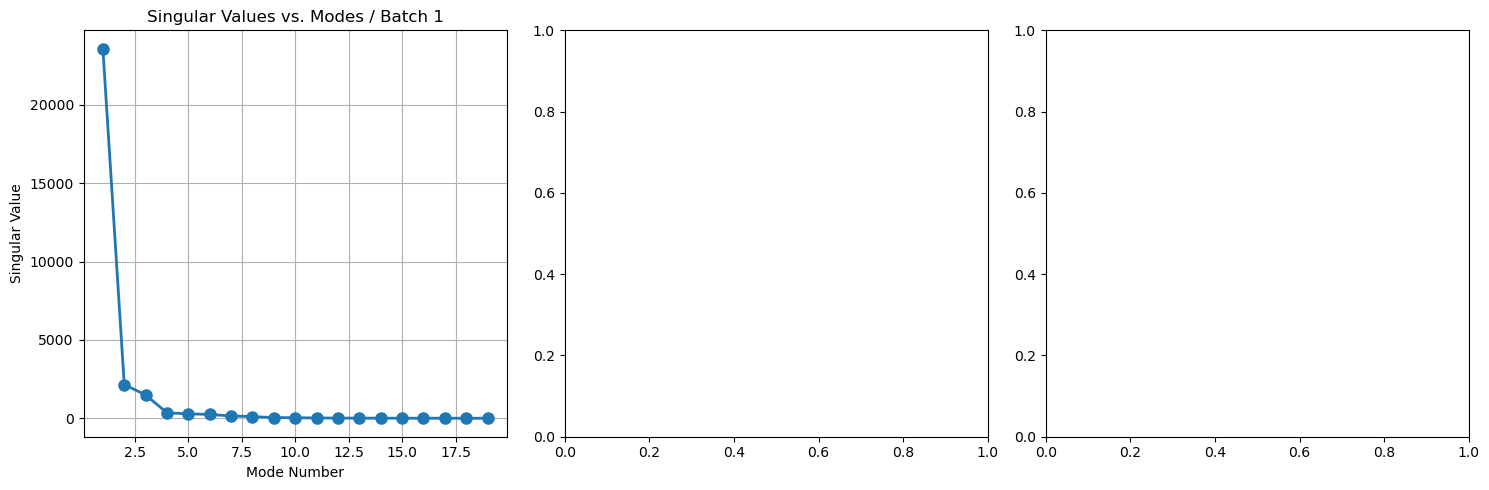

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np 

fig2, ax2 = plt.subplots(1, 3, figsize=(15, 5))

for i in range (0, 1):
    
    Sigma = np.array(lam ** 0.5)
    # Create an array for mode numbers (1-based index for readability)
    mode_ids = np.arange(1, len(Sigma) + 1)
    # Plotting the singular values vs. modes
    # ax1[0, i].figure(figsize=(8, 5))
    ax2[i].plot(mode_ids, Sigma, 'o-', linewidth=2, markersize=8)
    ax2[i].set_title(f'Singular Values vs. Modes / Batch {i+1}')
    ax2[i].set_xlabel('Mode Number')
    ax2[i].set_ylabel('Singular Value')
    ax2[i].grid(True)
    # ax1[0, i].show()

plt.tight_layout()
plt.show()

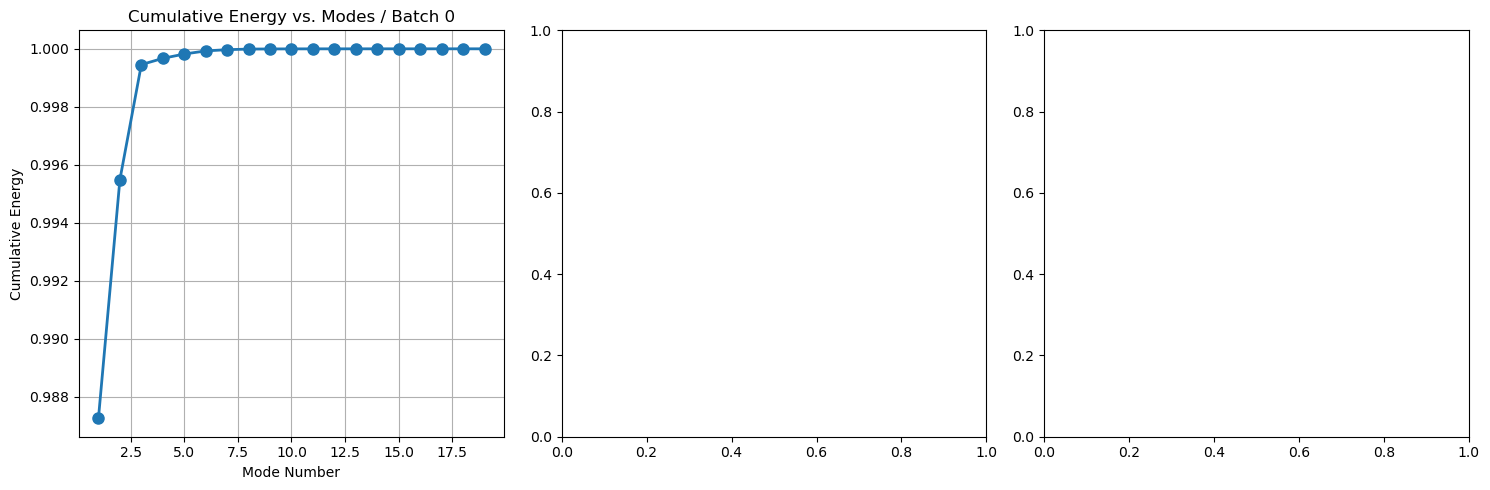

In [ ]:
fig3, ax3 = plt.subplots(1, 3, figsize=(15, 5))

for i in range (0, 1):
    
    Sigma = np.array(lam ** 0.5)
    
    # Create an array for mode numbers (1-based index for readability)
    mode_ids = np.arange(1, len(Sigma) + 1)

    # Calculate and plot cumulative energy
    cumulative_energy = np.cumsum(Sigma**2) / np.sum(Sigma**2)
    
    # Plotting the singular values vs. modes
    ax3[i].plot(mode_ids, cumulative_energy, 'o-', linewidth=2, markersize=8)
    ax3[i].set_title(f'Cumulative Energy vs. Modes / Batch {i}')
    ax3[i].set_xlabel('Mode Number')
    ax3[i].set_ylabel('Cumulative Energy')
    ax3[i].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# # -------------------------------------------------------------
# # 6)  IDW INTERPOLATION IN DOE SPACE  (example)
# # -------------------------------------------------------------
# # --- Load (or hard‑code) DOE table ---------------------------------------
# # Columns = design parameters; rows = snapshots
# try:
#     DOE = np.loadtxt("design_matrix.csv", delimiter=",")
# except FileNotFoundError:
#     print("⚠  design_matrix.csv not found – falling back to hard‑coded DOE")
#     DOE = np.array([
#         [2.29   , 0.28945, 5.611 , 1.289 , -0.01323],
#         [3.43775, 0.2429 , 5.0422, 0.132 ,  0.1657 ],
#         [2.42125, 0.8578 , 5.8   , -0.079, -0.14753],
#         [3.07875, 0.19495, 2.2   , 0.026 , -0.10248],
#         [4.     , 0.3844 , 2.7688, 0.868 , -0.023678],
#         [3.21   , 0.66835, 3.9046, -0.5  , -0.50538],
#         [1.76375, 0.4789 , 3.1468, -0.184, -0.44517],
#         [3.86875, 0.52615, 5.4202, 0.447 , -0.37108],
#         [2.68375, 0.7156 , 2.5798, 0.342 ,  0.3    ],
#         [3.73625, 0.81055, 4.0954, -0.395,  0.07645],
#         [3.605  , 0.7633 , 4.4734, 1.5   ,  0.0314 ],
#         [2.81625, 0.6211 , 3.7516, 1.395 , -0.55   ],
#         [1.63125, 0.57385, 5.2312, 0.763 , -0.46033],
#         [2.9475 , 0.14725, 3.3376, 1.184 ,  0.210325],
#         [2.5525 , 0.1    , 4.6624, 0.237 , -0.32645],
#         [2.1575 , 0.95275, 4.8532, 0.974 ,  0.121075],
#         [3.245  , 1.    , 2.566 , 0.553 , -0.2814 ],
#         [2.02625, 0.43165, 4.2844, -0.289,  0.255375],
#         [1.895  , 0.09055, 2.389 , 0.658 , -0.192115],
#         [1.5    , 0.3367 , 2.9578, 1.079 , -0.05785]
#     ])
    


# if DOE.shape[0] != 20:
#     raise RuntimeError("DOE row count does not match number of snapshots.")

# coeffs = VT.T   # (K, r)


# # -------------------------------------------------------------
# # 6)  RBF INTERPOLATION IN DOE SPACE  (cubic kernel)
# # -------------------------------------------------------------
# from scipy.interpolate import Rbf

# # -------------------------------------------------------------
# # Build one Rbf model *per POD mode* so we can predict coefficients
# # -------------------------------------------------------------
# rbf_models = []           # list length r
# coords = [DOE[:, i] for i in range(DOE.shape[1])]   # separate coordinate arrays

# for m in range(U.shape[1]):
#     rbf = Rbf(*coords, coeffs_mat[:, m], function='linear')  # radial basis fn
#     rbf_models.append(rbf)


# def coeff_interp_rbf(p_query: np.ndarray, models):
#     """Evaluate all RBF models at a query design vector → coefficient vector."""
#     vals = [model(*p_query) for model in models]
#     return np.array(vals)

# # --- example query --------------------------------------------------------
# new_design = np.array([2.29   , 0.28945, 5.611 , 1.289 , -0.01323])
# coeff_pred = coeff_interp_rbf(new_design, rbf_models)

# p_pred = U @ (S * coeff_pred)



In [ ]:
# denormalize_outputs = True  # <-- set True or False depending on your experiment

# # -------------------------------------------------------------
# # 6)  RBF INTERPOLATION IN DOE SPACE (multiple fields)
# # -------------------------------------------------------------
# from scipy.interpolate import Rbf

# # --- Load (or hard-code) DOE ----------------------------------
# try:
#     DOE = np.loadtxt("design_matrix.csv", delimiter=",")
# except FileNotFoundError:
#     print("⚠  design_matrix.csv not found – falling back to hard-coded DOE")
#     DOE = np.array([
#         [2.29, 0.28945, 5.611, 1.289, -0.01323],
#         [3.43775, 0.2429, 5.0422, 0.132, 0.1657],
#         [2.42125, 0.8578, 5.8, -0.079, -0.14753],
#         [3.07875, 0.19495, 2.2, 0.026, -0.10248],
#         [4., 0.3844, 2.7688, 0.868, -0.023678],
#         [3.21, 0.66835, 3.9046, -0.5, -0.50538],
#         [1.76375, 0.4789, 3.1468, -0.184, -0.44517],
#         [3.86875, 0.52615, 5.4202, 0.447, -0.37108],
#         [2.68375, 0.7156, 2.5798, 0.342, 0.3],
#         [3.73625, 0.81055, 4.0954, -0.395, 0.07645],
#         [3.605, 0.7633, 4.4734, 1.5, 0.0314],
#         [2.81625, 0.6211, 3.7516, 1.395, -0.55],
#         [1.63125, 0.57385, 5.2312, 0.763, -0.46033],
#         [2.9475, 0.14725, 3.3376, 1.184, 0.210325],
#         [2.5525, 0.1, 4.6624, 0.237, -0.32645],
#         [2.1575, 0.95275, 4.8532, 0.974, 0.121075],
#         [3.245, 1., 2.566, 0.553, -0.2814],
#         [2.02625, 0.43165, 4.2844, -0.289, 0.255375],
#         [1.895, 0.09055, 2.389, 0.658, -0.192115],
#         [1.5, 0.3367, 2.9578, 1.079, -0.05785]
#     ])

# # --- Build one RBF model per POD mode --------------------------
# rbf_models = []
# coords = [DOE[:, i] for i in range(DOE.shape[1])]

# for m in range(U.shape[1]):
#     rbf = Rbf(*coords, coeffs_mat[:, m], function='cubic', smooth=0)
#     rbf_models.append(rbf)

# def coeff_interp_rbf(p_query: np.ndarray, models):
#     """Evaluate all RBF models at a query design vector → coefficient vector."""
#     return np.array([model(*p_query) for model in models])

# # --- example design query --------------------------------------
# new_design = np.array([1.5, 0.3367, 2.9578, 1.079, -0.05785])
# coeff_pred = coeff_interp_rbf(new_design, rbf_models)

# # Reconstruct predicted flattened field
# x_pred = U @ (S * coeff_pred)  # shape (N_flat,)

# # Define number of points per scalar field
# N_grid = len(UV_query) if UV_grid else len(UV0)

# # Unpack slices
# Cp_pred    = x_pred[0:N_grid]
# tau_pred   = [x_pred[N_grid*(i+1):N_grid*(i+2)] for i in range(3)]  # tauw_0, tauw_1, tauw_2
# x_coord_pred = x_pred[N_grid*4 : N_grid*5]
# y_coord_pred = x_pred[N_grid*5 : N_grid*6]
# z_coord_pred = x_pred[N_grid*6 : N_grid*7]

# # -------------------------------------------------------------
# # De-normalize if necessary
# # -------------------------------------------------------------
# if normalize_snapshots and denormalize_outputs:
#     print("🔵 De-normalizing predicted fields...")

#     # Scalar fields
#     Cp_pred *= cp_scale
#     for i in range(3):
#         tau_pred[i] *= tau_scales[i]

#     # Geometry (if prediction of XYZ was enabled)
#     if predict_xyz:
#         x_coord_pred *= x_scale
#         y_coord_pred *= y_scale
#         z_coord_pred *= z_scale


⚠  design_matrix.csv not found – falling back to hard-coded DOE
🔵 De-normalizing predicted fields...


In [ ]:
# -------------------------------------------------------------
# 6)  INTERPOLATION IN DOE SPACE (RBF or Kriging)
# -------------------------------------------------------------
from scipy.interpolate import Rbf
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF as GP_RBF_Kernel

use_kriging = True          # <<< 🔥 Use Kriging (True) or RBF (False)
denormalize_outputs = False    # <<< 🔥 Keep as before

# --- Load (or hard-code) DOE ----------------------------------
try:
    DOE = np.loadtxt("design_matrix.csv", delimiter=",")
except FileNotFoundError:
    print("⚠  design_matrix.csv not found – falling back to hard-coded DOE")
    DOE = np.array([
        [2.29, 0.28945, 5.611, 1.289, -0.01323],
        [3.43775, 0.2429, 5.0422, 0.132, 0.1657],
        [2.42125, 0.8578, 5.8, -0.079, -0.14753],
        [3.07875, 0.19495, 2.2, 0.026, -0.10248],
        [4., 0.3844, 2.7688, 0.868, -0.023678],
        [3.21, 0.66835, 3.9046, -0.5, -0.50538],
        [1.76375, 0.4789, 3.1468, -0.184, -0.44517],
        [3.86875, 0.52615, 5.4202, 0.447, -0.37108],
        [2.68375, 0.7156, 2.5798, 0.342, 0.3],
        [3.73625, 0.81055, 4.0954, -0.395, 0.07645],
        [3.605, 0.7633, 4.4734, 1.5, 0.0314],
        [2.81625, 0.6211, 3.7516, 1.395, -0.55],
        [1.63125, 0.57385, 5.2312, 0.763, -0.46033],
        [2.9475, 0.14725, 3.3376, 1.184, 0.210325],
        [2.5525, 0.1, 4.6624, 0.237, -0.32645],
        [2.1575, 0.95275, 4.8532, 0.974, 0.121075],
        [3.245, 1., 2.566, 0.553, -0.2814],
        [2.02625, 0.43165, 4.2844, -0.289, 0.255375],
        [1.895, 0.09055, 2.389, 0.658, -0.192115],
        # [1.5, 0.3367, 2.9578, 1.079, -0.05785]
    ])

# --- Build one interpolation model per POD mode -----------------
interp_models = []
coords = [DOE[:, i] for i in range(DOE.shape[1])]
X_doe = np.column_stack(coords)  # (N_snapshots, N_design_params)

for m in range(U.shape[1]):
    y_m = coeffs_mat[:, m]  # POD coefficients for mode m

    if use_kriging:
        kernel = GP_RBF_Kernel(length_scale=np.ones(DOE.shape[1]))
        gp = GaussianProcessRegressor(kernel=kernel, normalize_y=False)
        gp.fit(X_doe, y_m)
        interp_models.append(gp)
    else:
        rbf = Rbf(*coords, y_m, function='linear')
        interp_models.append(rbf)

# --- Function to predict coefficients ---
def coeff_interp(design_query: np.ndarray, models):
    """Evaluate interpolation models at a query design vector → coefficient vector."""
    query = np.atleast_2d(design_query)

    if use_kriging:
        return np.array([model.predict(query)[0] for model in models])
    else:
        return np.array([model(*design_query) for model in models])

# --- Example design query ---
new_design = np.array([1.76375, 0.4789, 3.1468, 1.4, -1.5])
coeff_pred = coeff_interp(new_design, interp_models)

# --- Reconstruct predicted flattened field ---
x_pred = U @ (S * coeff_pred)  # (N_flat,)


# --- Unpack fields ---
N_grid = len(UV_query) if UV_grid else len(UV0)

Cp_pred    = x_pred[0:N_grid]
tau_pred   = [x_pred[N_grid*(i+1):N_grid*(i+2)] for i in range(3)]
x_coord_pred = x_pred[N_grid*4:N_grid*5]
y_coord_pred = x_pred[N_grid*5:N_grid*6]
z_coord_pred = x_pred[N_grid*6:N_grid*7]

# --- Undo non-dimensionalization (dimensionalize results) ---
# Use same reference values used during preprocessing
rho = 1025       # fluid density (kg/m^3)
U = 6.1728       # reference velocity (m/s)
p_inf = 0        # freestream pressure (assumed 0 during non-dim)

p_pred = Cp_pred * (rho * U**2) + p_inf
tauw_pred = [tau * (rho * U**2) for tau in tau_pred]  # dimensional wall shear stress


# --- De-normalize if needed ---
if normalize_snapshots and denormalize_outputs:
    print("🔵 De-normalizing predicted fields...")
    Cp_pred *= cp_scale
    for i in range(3):
        tau_pred[i] *= tau_scales[i]

    if predict_xyz:
        x_coord_pred *= x_scale
        y_coord_pred *= y_scale
        z_coord_pred *= z_scale


⚠  design_matrix.csv not found – falling back to hard-coded DOE


AttributeError: 'float' object has no attribute 'shape'

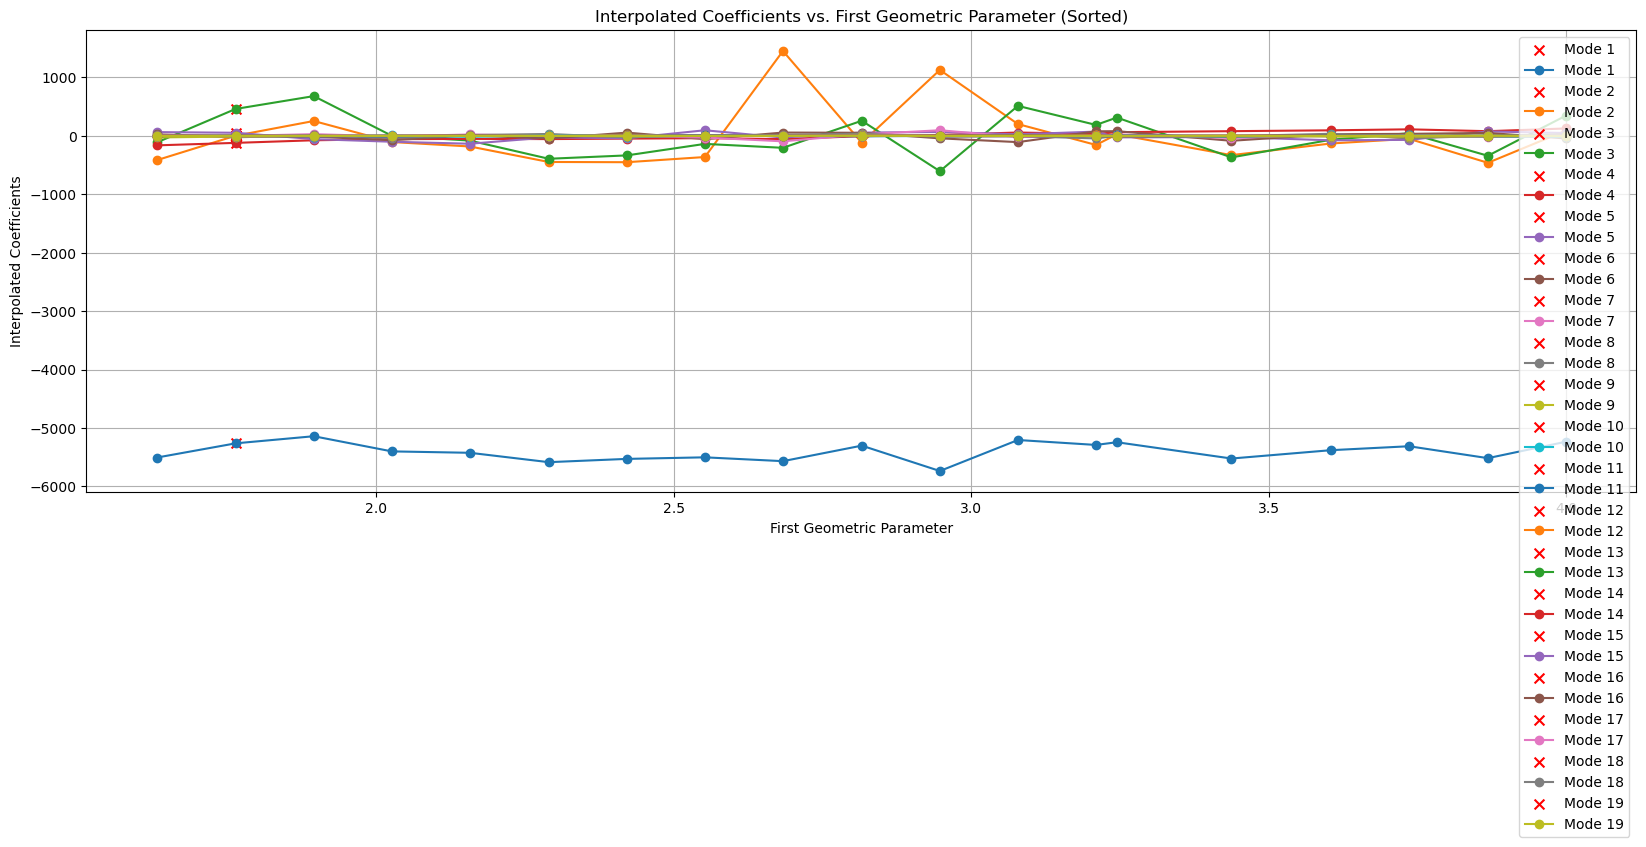

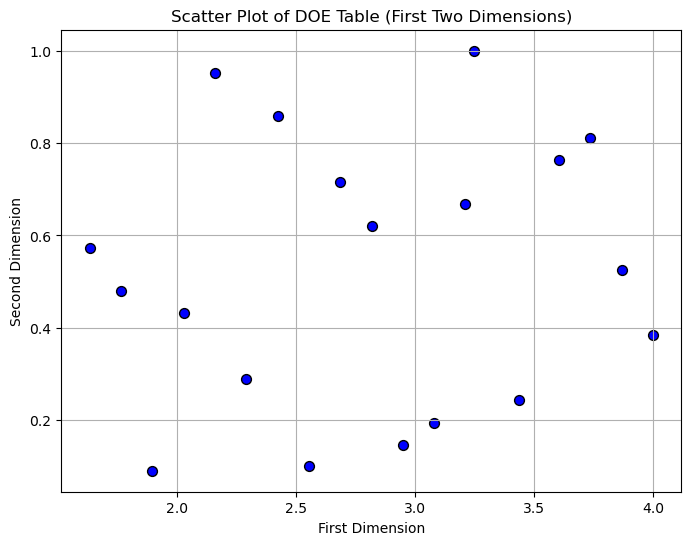

In [ ]:
import matplotlib.pyplot as plt

# Extract the first geometric parameter from the DOE matrix
first_param = DOE[:, 0]

# # Plot the interpolated coefficients versus the first geometric parameter
# plt.figure(figsize=(10, 6))
# for i, coeff in enumerate(coeff_pred):
#     plt.plot(first_param, coeffs_mat[:, i], 'o-', label=f'Mode {i+1}')

# plt.title('Interpolated Coefficients vs. First Geometric Parameter')
# plt.xlabel('First Geometric Parameter')
# plt.ylabel('Interpolated Coefficients')
# plt.legend()
# plt.grid(True)
# plt.show()

# Sort the DOE matrix and coefficients by the first parameter
sorted_indices = np.argsort(first_param)
first_param_sorted = first_param[sorted_indices]
coeffs_mat_sorted = coeffs_mat[sorted_indices]

# Plot the sorted interpolated coefficients versus the first geometric parameter
plt.figure(figsize=(20, 6))
for i, coeff in enumerate(coeff_pred):
    plt.scatter(new_design[0], coeff_pred[i], s=50, marker='x', color='red', label=f'Mode {i+1}')
    plt.plot(first_param_sorted, coeffs_mat_sorted[:, i], 'o-', label=f'Mode {i+1}')
    

plt.title('Interpolated Coefficients vs. First Geometric Parameter (Sorted)')
plt.xlabel('First Geometric Parameter')
plt.ylabel('Interpolated Coefficients')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot of the DOE table (first two dimensions)
plt.figure(figsize=(8, 6))
plt.scatter(DOE[:, 0], DOE[:, 1], c='blue', edgecolor='k', s=50)
plt.title('Scatter Plot of DOE Table (First Two Dimensions)')
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.grid(True)
plt.show()

In [ ]:
# -------------------------------------------------------------
# 7) Build and visualise predicted hull (for multiple fields)
# -------------------------------------------------------------

predict_xyz = False    


# Build a dictionary of predicted scalar fields
pred_fields = {
    "Cp": Cp_pred,
    "tauw_0": tau_pred[0],
    "tauw_1": tau_pred[1],
    "tauw_2": tau_pred[2],
}

# Optional: re-dimensionalized
pred_fields_dim = {
    "p_pred": p_pred,
    "tau_0": tauw_pred[0],
    "tau_1": tauw_pred[1],
    "tau_2": tauw_pred[2],
}

# Stack predicted XYZ coordinates
if predict_xyz:
    predicted_XYZ = np.column_stack((x_coord_pred, y_coord_pred, z_coord_pred))  # (N_grid, 3)

# -------------------------------------------------------------
# Create UV prediction mesh (Structured or Unstructured)
# -------------------------------------------------------------
if UV_grid:
    uv_pred = pv.StructuredGrid(UU, VV, np.zeros_like(UU))
else:
    uv_pts = np.column_stack((UV0, np.zeros(len(UV0))))
    uv_pred = pv.PolyData(uv_pts, faces_pv.copy())

# for name, data in pred_fields.items():
#     uv_pred.point_data[name] = data
    
for name, data in pred_fields_dim.items():
    uv_pred.point_data[name] = data

# -------------------------------------------------------------
# Create 3D prediction mesh
# -------------------------------------------------------------
if UV_grid:
    mesh_pred = pv.PolyData(V0.copy(), faces_pv.copy())  # Base mesh: original points (V0)

    for name, data in pred_fields.items():
        interp_data = griddata(UV_query, data, UV0, method='cubic')
        nan_idx = np.isnan(interp_data)
        if np.any(nan_idx):
            interp_data[nan_idx] = griddata(UV_query, data, UV0[nan_idx], method='nearest')
        mesh_pred.point_data[name] = interp_data

    if predict_xyz:
        pred_X = griddata(UV_query, predicted_XYZ[:, 0], UV0, method='cubic')
        pred_Y = griddata(UV_query, predicted_XYZ[:, 1], UV0, method='cubic')
        pred_Z = griddata(UV_query, predicted_XYZ[:, 2], UV0, method='cubic')

        nan_X = np.isnan(pred_X)
        nan_Y = np.isnan(pred_Y)
        nan_Z = np.isnan(pred_Z)
        if np.any(nan_X): pred_X[nan_X] = griddata(UV_query, predicted_XYZ[:,0], UV0[nan_X], method='nearest')
        if np.any(nan_Y): pred_Y[nan_Y] = griddata(UV_query, predicted_XYZ[:,1], UV0[nan_Y], method='nearest')
        if np.any(nan_Z): pred_Z[nan_Z] = griddata(UV_query, predicted_XYZ[:,2], UV0[nan_Z], method='nearest')

        # Replace geometry
        mesh_pred.points = np.column_stack((pred_X, pred_Y, pred_Z))

else:
    if predict_xyz:
        mesh_pred = pv.PolyData(predicted_XYZ.copy(), faces_pv.copy())
    else:
        mesh_pred = pv.PolyData(V0.copy(), faces_pv.copy())

    for name, data in pred_fields_dim.items():
        print (name, data.shape)
        mesh_pred.point_data[name] = data

# -------------------------------------------------------------
# Visualise all predicted scalar fields
# -------------------------------------------------------------
plt2_p = pv.Plotter(shape=(1, 2), window_size=(900, 300*1))

plt2_p.subplot(0, 0)
# clim_3d_pred = [0,200]
plt2_p.add_mesh(mesh_pred, scalars='p_pred', cmap="coolwarm", show_edges=False)
plt2_p.add_text(f"Predicted 3D hull: {name}")

plt2_p.subplot(0, 1)
# clim_uv_pred = [0, 0.0001]  # Static color limit (optional you can automate)
plt2_p.add_mesh(uv_pred, scalars='p_pred', cmap="coolwarm", show_edges=False)
plt2_p.add_text(f"Predicted UV map: {name}")
plt2_p.view_xy()  # Always XY view

plt2_p.show()


#TODO: geometry of hull is parasolid and then stl 



p_pred (139399,)
tau_0 (139399,)
tau_1 (139399,)
tau_2 (139399,)


Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x283f044eb10_83&reconnect=auto" class="pyvi…

In [ ]:

# -------------------------------------------------------------
# Visualise all predicted scalar fields
# -------------------------------------------------------------
plt2 = pv.Plotter(shape=(len(pred_fields), 2), window_size=(900, 300*len(pred_fields)))

for i, (name, _) in enumerate(pred_fields_dim.items()):
    
    if name!="Cp":
        plt2.subplot(i, 0)
        # clim_3d_pred = [0,200]
        plt2.add_mesh(mesh_pred, scalars=name, cmap="coolwarm", show_edges=False)
        plt2.add_text(f"Predicted 3D hull: {name}")

        plt2.subplot(i, 1)
        # clim_uv_pred = [0, 0.0001]  # Static color limit (optional you can automate)
        plt2.add_mesh(uv_pred, scalars=name, cmap="coolwarm", show_edges=False)
        plt2.add_text(f"Predicted UV map: {name}")
        plt2.view_xy()  # Always XY view

plt2.show()

# -------------------------------------------------------------
# Print scalar field summaries
# -------------------------------------------------------------
print(f"Maximum Cp value: {pred_fields['tauw_0'].max()}")
print(f"Minimum Cp value: {pred_fields['tauw_0'].min()}")

Widget(value='<iframe src="http://localhost:51306/index.html?ui=P_0x283a7e878f0_82&reconnect=auto" class="pyvi…

Maximum Cp value: 33.922027990132676
Minimum Cp value: -0.20336326231528226


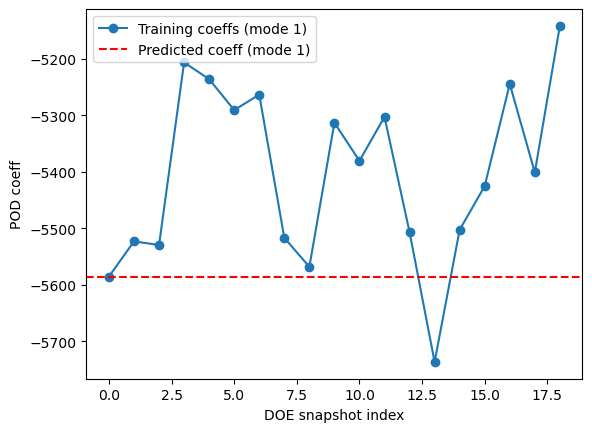

In [ ]:
import matplotlib.pyplot as plt

# Plot predicted vs training coefficients for first few modes
fig, ax = plt.subplots()
ax.plot(np.arange(len(coeffs_mat[:,0])), coeffs_mat[:,0], 'o-', label='Training coeffs (mode 1)')
ax.axhline(y=coeff_pred[0], color='r', linestyle='--', label='Predicted coeff (mode 1)')
ax.set_xlabel('DOE snapshot index')
ax.set_ylabel('POD coeff')
ax.legend()
plt.show()



In [ ]:
# # 7)  Build and visualise predicted hull ----------------------------------


# if UV_grid:

#     # # p_pred shape must match UV_query (structured grid points, len=10000)
#     # # UV_query: structured grid (10000 points)
#     # # UV0: original mesh harmonic UV points (121961 points)

#     # # Cubic interpolation onto original mesh UV points
#     # p_pred_on_V0 = griddata(UV_query, p_pred, UV0, method='cubic')

#     # # Handle any points outside convex hull
#     # nan_indices = np.isnan(p_pred_on_V0)
#     # if np.any(nan_indices):
#     #     p_pred_on_V0[nan_indices] = griddata(UV_query, p_pred, UV0[nan_indices], method='nearest')

#     # # Check lengths explicitly
#     # print("Length of V0 points:", len(V0))
#     # print("Length of interpolated p_pred_on_V0:", len(p_pred_on_V0))

#     # # Ensure no NaNs remain
#     # assert not np.any(np.isnan(p_pred_on_V0)), "Interpolation still contains NaNs!"

#     # # Faces definition for PyVista (important!)
#     # faces_pv = np.hstack((np.full((F0.shape[0], 1), 3), F0)).astype(np.int64)

#     # # Construct final mesh
#     # mesh_pred = pv.PolyData(V0, faces_pv)

#     # # Add scalar field correctly
#     # mesh_pred.point_data["p_pred"] = p_pred_on_V0

#     uv_pred = pv.StructuredGrid(UU, VV, np.zeros_like(UU))
#     uv_pred.point_data["p_pred"] = p_pred
# else:
#     mesh_pred = pv.PolyData(V0, faces_pv)
#     mesh_pred.point_data["p_pred"] = p_pred
#     uv_pred   = pv.PolyData(np.column_stack((UV0, np.zeros(len(UV0)))), faces_pv.copy())
#     uv_pred.point_data["p_pred"] = p_pred

# plt2 = pv.Plotter(shape=(1, 2))
# plt2.subplot(0, 0)
# plt2.add_mesh(mesh_pred, scalars="p_pred", cmap="coolwarm", show_edges=False)
# plt2.add_text("Predicted 3‑D hull (p_pred)")
# plt2.subplot(0, 1)
# # clim = [-0.1,0.1]
# clim = uv_pred.point_data["p_pred"].min(), uv_pred.point_data["p_pred"].max()
# plt2.add_mesh(uv_pred, scalars="p_pred", clim=clim, cmap="coolwarm", show_edges=True)
# plt2.add_text("Predicted UV (p_pred)")
# plt2.show()

# # TODO: need to check prediction of XYZ points, need to check why rotation is happening - probably due to cutting off the top of the hull

NameError: name 'p_pred' is not defined

In [ ]:
uv_pred = pv.StructuredGrid(UU, VV, np.zeros_like(UU))
uv_pred.point_data["p_pred"] = p_pred

In [ ]:
# plot snapshots grid
plt=pv.Plotter(shape=(1,2),window_size=(800,200*1))

for k in range(1):
    clim_mesh = all_hull_meshes[k].point_data["p"].min(), all_hull_meshes[k].point_data["p"].max()
    clim_uv   = all_uv_meshes[k].point_data["p"].min(), all_uv_meshes[k].point_data["p"].max()
    plt.subplot(k,0); plt.add_mesh(all_hull_meshes[k], clim=clim_mesh, scalars='p',cmap='coolwarm'); plt.add_text(case_paths[k][0])
    plt.subplot(k,1); plt.add_mesh(all_uv_meshes[k], clim = clim_uv, scalars='p',cmap='coolwarm'); plt.add_text(case_paths[k][0])
plt.show()

IndexError: list index out of range

In [ ]:
file = "Z:\Zack\Data\Incoming\Cat_parametric_study\High_Fidelity\RUN001\case.foam"
# case_paths = [(f"RUN{i:03d}", os.path.join(BASE_DIR, f"RUN{i:03d}", "case.foam"))
#               for i in RUN_RANGE if os.path.exists(os.path.join(BASE_DIR, f"RUN{i:03d}", "case.foam"))]
# if not case_paths:
#     sys.exit("No .foam files found – check BASE_DIR.")

# # template build
# run0, foam0 = case_paths[0]
hull_ = extract_hull_mesh(file)


<>:1: SyntaxWarning: invalid escape sequence '\Z'
<>:1: SyntaxWarning: invalid escape sequence '\Z'
C:\Users\zack\AppData\Local\Temp\ipykernel_34764\2831916729.py:1: SyntaxWarning: invalid escape sequence '\Z'
  file = "Z:\Zack\Data\Incoming\Cat_parametric_study\High_Fidelity\RUN001\case.foam"
ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (0000026E97344A70) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0


In [ ]:

# Plot original hull with boundary overlay
p = pv.Plotter()
p.add_mesh(pv.wrap(hull_), scalars="p", cmap='coolwarm', opacity=0.9, show_edges=True)
p.show()


Widget(value='<iframe src="http://localhost:51790/index.html?ui=P_0x26f12ba1b50_18&reconnect=auto" class="pyvi…

In [ ]:
cleaned_hull = remove_hull_deck(hull_)
# Plot original hull with boundary overlay
p = pv.Plotter()
p.add_mesh(pv.wrap(cleaned_hull),scalars="p", cmap='coolwarm',  opacity=0.9, show_edges=True)
p.show()



⚠️ Some normals point inward!


Widget(value='<iframe src="http://localhost:51790/index.html?ui=P_0x26eb8cded20_19&reconnect=auto" class="pyvi…

In [ ]:
import pyvista as pv
import numpy as np

def remove_skewed_triangles(tri_mesh, max_aspect_ratio=1):
    # Ensure triangulated
    # tri_mesh = mesh.triangulate()

    # Get faces (n_triangles, 3)
    faces = tri_mesh.cells.reshape(-1, 4)[:, 1:]
    points = tri_mesh.points

    good_cells = []
    for i, (a, b, c) in enumerate(faces):
        A, B, C = points[a], points[b], points[c]

        # Compute edge lengths
        ab = np.linalg.norm(A - B)
        bc = np.linalg.norm(B - C)
        ca = np.linalg.norm(C - A)

        lengths = np.array([ab, bc, ca])
        max_len = lengths.max()
        min_len = lengths.min()

        if min_len == 0:
            continue

        aspect_ratio = max_len / min_len
        if aspect_ratio < max_aspect_ratio:
            good_cells.append(i)

    # Extract non-skewed triangles
    return tri_mesh.extract_cells(good_cells)


def all_mesh_edges(faces):
    edges = set()
    for tri in faces:
        a, b, c = tri
        for u, v in [(a, b), (b, c), (c, a)]:
            edge = tuple(sorted((u, v)))
            if edge in edges:
                edges.remove(edge)  # Remove if already exists (internal edge)
            else:
                edges.add(edge)     # Add new edge
    return edges

import numpy as np
import pyvista as pv

def flip_inward_normals(mesh: pv.PolyData, verbose=True) -> pv.PolyData:
    """
    Detects and flips only the faces with inward-pointing normals in a PyVista mesh.

    Parameters:
    - mesh (pv.PolyData): The input triangle surface mesh
    - verbose (bool): If True, prints diagnostics

    Returns:
    - pv.PolyData: The mesh with corrected face windings
    """
    mesh = mesh.extract_surface()
    mesh = mesh.compute_normals(cell_normals=True, point_normals=False, auto_orient_normals=True)

    normals = mesh.cell_data["Normals"]
    centers = mesh.cell_centers().points
    center = mesh.center

    # Check if normals point outward from the center
    directions = centers - center
    dot_signs = np.einsum("ij,ij->i", normals, directions)
    flip_ids = np.where(dot_signs < 0)[0]

    if verbose:
        print(f"🔎 Found {len(flip_ids)} inward-facing faces to flip.")

    if len(flip_ids) == 0:
        return mesh

    # Flip triangle winding for these faces
    faces = mesh.faces.reshape(-1, 4).copy()
    faces[flip_ids, [1, 3]] = faces[flip_ids, [3, 1]]  # Swap vertices

    flipped_mesh = pv.PolyData(mesh.points, faces)
    flipped_mesh = flipped_mesh.clean()  # Optional cleanup
    flipped_mesh = flipped_mesh.compute_normals(cell_normals=True, point_normals=False, auto_orient_normals=False)

    return flipped_mesh




In [ ]:
print ('Hello, world!')

# # 1. Extract surface
# hull_surface = hull.extract_surface()

# cleaned_hull = remove_hull_deck(hull_, False)
# cleaned_hull = cleaned_hull.remove_degenerate_cells()

#=======================================================
# cleaned_hull = cleaned_hull.clean(tolerance=1e-9)

# # Thise is important
cleaned_hull = cleaned_hull.triangulate()
# cleaned_hull = cleaned_hull.connectivity()
# cleaned_hull = cleaned_hull.extract_surface().fill_holes(hole_size=1000)


# cleaned_hull["Area"] = cleaned_hull.compute_cell_sizes()["Area"]
# areas = cleaned_hull.compute_cell_sizes()["Area"]
# # area_threshold = 0.00000000001 * np.mean(areas)  # or use np.median
# cleaned_hull = cleaned_hull.threshold(value=1e-7, scalars="Area").clean(tolerance=1e-5) #TODO: this seems to solve missing boundary loop
# # cleaned_hull = cleaned_hull.threshold(value=area_threshold, scalars="Area")

# measures = ['area', 'shape', 'min_angle', 'max_angle']
# cleaned_hull_quality = cleaned_hull.compute_cell_quality('max_angle')  # Use cell_quality directly on cleaned_hull
# qualities = cleaned_hull_quality.cell_data["CellQuality"]

#=======================================================
# # Check for non-manifold edges
# feature_edges = vtk.vtkFeatureEdges()
# feature_edges.SetInputData(cleaned_hull)
# feature_edges.BoundaryEdgesOn()
# feature_edges.NonManifoldEdgesOn()
# feature_edges.ManifoldEdgesOff()
# feature_edges.FeatureEdgesOff()
# feature_edges.Update()
# nonmanifold_edges = feature_edges.GetOutput()
# print("Non-manifold edge count:", nonmanifold_edges.GetNumberOfCells())

F = cleaned_hull.faces.reshape(-1, 4)[:, 1:].astype(np.int32)
V = cleaned_hull.points.astype(float)

# Extract boundary edges as vertex index pairs
boundary_edges = igl.boundary_facets(F)  # shape (n_edges, 2)

# Get the corresponding 3D points for each edge endpoint
lines = []
for i, j in boundary_edges:
    lines.append([2, i, j])  # '2' means line with 2 points

lines = np.array(lines).flatten()

# Create the PyVista object
edge_mesh = pv.PolyData()
edge_mesh.points = V
edge_mesh.lines = lines

import networkx as nx

# --- Extract boundary edges using igl ---
F = cleaned_hull.faces.reshape(-1, 4)[:, 1:].astype(np.int32)
V = cleaned_hull.points.astype(float)
boundary_edges = igl.boundary_facets(F)

# --- Build graph from boundary edges ---
G = nx.Graph()
G.add_edges_from(boundary_edges)

# --- Extract connected loops ---
loops = list(nx.connected_components(G))
loops_sorted = sorted(loops, key=len, reverse=True)

# --- Order loop points using DFS ---
ordered_loops = []
for loop in loops_sorted:
    subgraph = G.subgraph(loop)
    path = list(nx.dfs_edges(subgraph))
    if path:
        ordered_loop = [path[0][0]] + [v for _, v in path]
        ordered_loops.append(ordered_loop)

# --- Visualize largest boundary loop ---
p_ = pv.Plotter()  # Initialize the Plotter object
if ordered_loops:
    loop_indices = ordered_loops[0]
    loop_pts = V[loop_indices]
    p.add_mesh(pv.PolyData(loop_pts), color='green', point_size=5, render_points_as_spheres=True, label='Ordered Loop')


# # Original scalar pressure
if "p" in cleaned_hull.point_data:
    p_scalar = cleaned_hull.point_data["p"].astype(float)
else:
    print("Warning: 'p' data not found in cleaned_hull. Using default values.")
    p_scalar = np.zeros(cleaned_hull.n_points)  # Default to zeros

if "tauw" in cleaned_hull.point_data:
    tau_wall = cleaned_hull.point_data["tauw"].astype(float)  # shape (N, 3)
else:
    print("Warning: 'tauw' data not found in cleaned_hull. Using default values.")
    tau_wall = np.zeros((cleaned_hull.n_points, 3))  # Default to zeros

# Plot original hull with boundary overlay
p_.add_mesh(pv.wrap(cleaned_hull), color='lightgray', opacity=0.9, show_edges=True)
p_.add_mesh(edge_mesh, color='red', line_width=2, label='Boundary Edges')
p_.add_mesh(loop_pts, color='green', line_width=2, label='Boundary Edges')
p_.add_legend()
p_.show()

# # --- 5. Visualize ---
# plotter__ = pv.Plotter()
# # plotter__.add_mesh(tri_hull, show_edges=True, opacity=0.4)
# # plotter__.add_mesh(boundary_lines, color='red', line_width=3, label="Boundary Edges")
# plotter__.add_mesh(cleaned_hull, scalars=p_scalar, show_edges=False)
# plotter__.add_text("Cleaned Hull + Boundary", font_size=12)
# # plotter__.add_legend()
# plotter__.show()


# # Extract the indices of the boundary edges
# boundary_edge_indices = boundary_facets.flatten()

# # Extract the x and y coordinates of the boundary lines
# boundary_x = V[boundary_edge_indices].reshape(-1, 2, 3)[:, :, 0]
# boundary_y = V[boundary_edge_indices].reshape(-1, 2, 3)[:, :, 1]

# # Plot the boundary lines
# plt.figure(figsize=(10, 6))
# for x, y in zip(boundary_x, boundary_y):
#     plt.plot(x, y, color='red', linewidth=0.5)

# plt.title("Boundary Lines (2D View)")
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.axis('equal')
# plt.grid(True)
# plt.show()

Hello, world!


Widget(value='<iframe src="http://localhost:51790/index.html?ui=P_0x26eb9f434d0_15&reconnect=auto" class="pyvi…

In [ ]:
# Degrees of boundary vertices
degrees = dict(G.degree())
open_ends = [k for k, v in degrees.items() if v == 1]

print(f"Open ends in boundary graph: {len(open_ends)}")

p = pv.Plotter()
p.add_mesh(cleaned_hull, opacity=1)
p.add_points(V[open_ends], color='blue', point_size=10)
# p.add_legend()
p.show()


Open ends in boundary graph: 0


ValueError: Empty meshes cannot be plotted. Input mesh has zero points. To allow plotting empty meshes, set `pv.global_theme.allow_empty_mesh = True`

In [ ]:
b = igl.boundary_loop(F)
print(f"Boundary loop length: {len(b)}")


Boundary loop length: 4291


In [ ]:
# UV_src = harmonic_uv(V, F, USE_SQUARE)
# tris_uv = UV_src[F]
# cent    = tris_uv.mean(axis=1)
# tree    = cKDTree(cent)
# uv_min  = tris_uv.min(axis=1)
# uv_max  = tris_uv.max(axis=1)
# Compute the harmonic UV map for the cleaned hull
# V_cleaned = cleaned_hull.points.astype(float)
# F_cleaned = cleaned_hull.cells.reshape(-1, 4)[:, 1:].astype(np.int32)
UV_cleaned = harmonic_uv(V, F, USE_SQUARE)

# Visualize the harmonic UV map
uv_pts_cleaned = np.column_stack((UV_cleaned, np.zeros(len(UV_cleaned))))
faces_cleaned = np.hstack((np.full((F.shape[0], 1), 3), F)).astype(int)
mesh_uv_cleaned = pv.PolyData(uv_pts_cleaned, faces_cleaned)

plotter = pv.Plotter()
plotter.add_mesh(mesh_uv_cleaned, scalars=p_scalar, cmap="coolwarm", show_edges=True)
# plotter.add_mesh(mesh_uv_cleaned, color='red', show_edges=True)
plotter.add_text("Harmonic UV Map of Cleaned Hull", font_size=12)
plotter.show()


Widget(value='<iframe src="http://localhost:51790/index.html?ui=P_0x26f12c0a720_17&reconnect=auto" class="pyvi…

In [ ]:
print("Loading cases …")
case_paths = [(f"RUN{i:03d}", os.path.join(BASE_DIR, f"RUN{i:03d}", "case.foam"))
              for i in RUN_RANGE if os.path.exists(os.path.join(BASE_DIR, f"RUN{i:03d}", "case.foam"))]
if not case_paths:
    sys.exit("No .foam files found – check BASE_DIR.")

# template build
run0, foam0 = case_paths[0]
hull0 = extract_hull_mesh(foam0)
hull0 = remove_hull_deck(hull0)
V0 = hull0.points.astype(float)
F0 = hull0.cells.reshape(-1,4)[:,1:].astype(np.int32)
if UV_grid:
    # Instead of UV0 = harmonic_uv(V0, F0)
    
    # Prepare UV sampling grid
    nu = nv = 100
    u_lin = np.linspace(0,1,nu)
    v_lin = np.linspace(0,1,nv)
    UU, VV = np.meshgrid(u_lin, v_lin)
    UV_query = np.column_stack((UU.ravel(), VV.ravel()))
    M = UV_query.shape[0]

    print("UV sampling grid:")
    print(f"  {nu} x {nv} = {M} points")

    u_lin = np.linspace(0, 1, nu)
    v_lin = np.linspace(0, 1, nv)
    UU, VV = np.meshgrid(u_lin, v_lin)
    UV0 = np.column_stack((UU.ravel(), VV.ravel()))
else:
    UV0 = harmonic_uv(V0,F0,USE_SQUARE)
    
faces_pv = np.hstack((np.full((F0.shape[0],1),3),F0)).astype(int)

Loading cases …


ERROR:root:Input for connection index 0 on input port index 0 for algorithm vtkFeatureEdges (0000018BF46743E0) is of type vtkUnstructuredGrid, but a vtkPolyData is required.


Non-manifold edge count: 0


In [ ]:


# Visualize the harmonic UV map
uv_pts_cleaned = np.column_stack((UV0, np.zeros(len(UV0))))
faces_cleaned = np.hstack((np.full((F0.shape[0], 1), 3), F0)).astype(int)
mesh_uv_cleaned = pv.PolyData(uv_pts_cleaned, faces_cleaned)

plotter_i= pv.Plotter()
plotter_i.add_mesh(mesh_uv_cleaned, cmap="coolwarm", show_edges=True)
plotter_i.add_text("Harmonic UV Map of Cleaned Hull", font_size=12)
plotter_i.show()

Widget(value='<iframe src="http://localhost:49258/index.html?ui=P_0x18a62e11220_18&reconnect=auto" class="pyvi…